In [2172]:
#import Optimal Binning, and the sklearn libraries we need for this process
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from optbinning import OptimalBinning  #you may need to "pip install optbinning" if you don't already have this library
from optbinning import Scorecard
from optbinning.scorecard import ScorecardMonitoring
from optbinning import BinningProcess
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import pandas as pd
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_rows', None)


In [2173]:
dfs = pd.read_excel('fixed_credit_data.xlsx')


In [2307]:
df = dfs.copy()

In [2308]:
df.head()

,Unnamed: 0,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_length,installment_rate,personal_status,...,age,installment_plan,housing,existing_credits,default,dependents,foreign_worker,job,gender,IsDefault
0,0,-43,6,critical,radio/tv,1169,0,13 years,4,single,...,67,none,own,2,0,1,yes,skilled employee,male,Good
1,1,75,48,repaid,radio/tv,5951,89,2 years,2,Unknown,...,22,none,own,1,1,1,yes,skilled employee,female,Bad
2,2,0,12,critical,education,2096,24,5 years,2,single,...,49,none,own,1,0,2,yes,unskilled resident,male,Good
3,3,-32,42,repaid,furniture,7882,9,5 years,2,single,...,45,none,for free,1,0,2,yes,skilled employee,male,Good
4,4,-23,24,delayed,car (new),4870,43,3 years,3,single,...,53,none,for free,2,1,2,yes,skilled employee,male,Bad


In [2309]:
df.drop(columns=['Unnamed: 0', 'IsDefault'], inplace=True)
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (1000, 21)


,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_length,installment_rate,personal_status,other_debtors,...,property,age,installment_plan,housing,existing_credits,default,dependents,foreign_worker,job,gender
0,-43,6,critical,radio/tv,1169,0,13 years,4,single,none,...,real estate,67,none,own,2,0,1,yes,skilled employee,male
1,75,48,repaid,radio/tv,5951,89,2 years,2,Unknown,none,...,real estate,22,none,own,1,1,1,yes,skilled employee,female
2,0,12,critical,education,2096,24,5 years,2,single,none,...,real estate,49,none,own,1,0,2,yes,unskilled resident,male
3,-32,42,repaid,furniture,7882,9,5 years,2,single,guarantor,...,building society savings,45,none,for free,1,0,2,yes,skilled employee,male
4,-23,24,delayed,car (new),4870,43,3 years,3,single,none,...,unknown/none,53,none,for free,2,1,2,yes,skilled employee,male


In [2310]:
df.columns

Index(['checking_balance', 'months_loan_duration', 'credit_history', 'purpose',
       'amount', 'savings_balance', 'employment_length', 'installment_rate',
       'personal_status', 'other_debtors', 'residence_history', 'property',
       'age', 'installment_plan', 'housing', 'existing_credits', 'default',
       'dependents', 'foreign_worker', 'job', 'gender'],
      dtype='object')

In [2311]:
# df['amount'] = np.log1p(df['amount'])  # log1p handles 0s properly (log(0) is undefined)

# Helper function to convert employment length to numeric years
def employment_length_to_years(s):
    if 'year' in s:
        return int(s.split()[0])
    elif 'month' in s:
        return int(s.split()[0]) / 12
    return np.nan

# Convert employment_length to numeric years, treating "Unknown" as NaN for now
df['employment_length_years'] = df['employment_length'].apply(lambda x: employment_length_to_years(x) if x != "Unknown" else np.nan)
df['employment_length_years'].fillna(df['employment_length_years'].median(), inplace=True)


# Convert residence_history to numeric years, treating "Unknown" as NaN for now
df['residence_history_years'] = df['residence_history'].apply(lambda x: employment_length_to_years(x) if x != "Unknown" else np.nan)
df['residence_history_years'].fillna(df['residence_history_years'].median(), inplace=True)

df.head()


/Users/macbookpro/anaconda3/envs/renmoney_m1/lib/python3.10/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_length,installment_rate,personal_status,other_debtors,...,installment_plan,housing,existing_credits,default,dependents,foreign_worker,job,gender,employment_length_years,residence_history_years
0,-43,6,critical,radio/tv,1169,0,13 years,4,single,none,...,none,own,2,0,1,yes,skilled employee,male,13.0,6.000000
1,75,48,repaid,radio/tv,5951,89,2 years,2,Unknown,none,...,none,own,1,1,1,yes,skilled employee,female,2.0,0.416667
2,0,12,critical,education,2096,24,5 years,2,single,none,...,none,own,1,0,2,yes,unskilled resident,male,5.0,4.000000
3,-32,42,repaid,furniture,7882,9,5 years,2,single,guarantor,...,none,for free,1,0,2,yes,skilled employee,male,5.0,13.000000
4,-23,24,delayed,car (new),4870,43,3 years,3,single,none,...,none,for free,2,1,2,yes,skilled employee,male,3.0,13.000000


In [2312]:
missing_zero_values_table(df)

Your selected dataframe has 23 columns and 1000 Rows.
There are 23 columns that have missing values.


,No of 0s,% of 0s,No of Missing Values,% of Missing Values,Rows,No of Unique,Data Type
checking_balance,394,0.394,0,0.0,1000,264,int64
months_loan_duration,0,0.000,0,0.0,1000,33,int64
credit_history,0,0.000,0,0.0,1000,5,object
purpose,0,0.000,0,0.0,1000,10,object
amount,0,0.000,0,0.0,1000,921,int64
savings_balance,191,0.191,0,0.0,1000,302,int64
employment_length,0,0.000,0,0.0,1000,32,object
installment_rate,0,0.000,0,0.0,1000,4,int64
personal_status,0,0.000,0,0.0,1000,4,object
other_debtors,0,0.000,0,0.0,1000,3,object


In [2313]:
# 1. Interaction Features
df['installment_rate_amount'] = df['installment_rate'] * df['amount']

# 2. Aggregated Features
df['savings_to_amount_ratio'] = df['savings_balance'] / (df['amount'] + 1)  # Adding 1 to avoid division by zero

# 3. Time-Based Features
# Convert the columns to numeric, coerce errors to NaN (Not a Number)
df['months_loan_duration'] = pd.to_numeric(df['months_loan_duration'], errors='coerce')
df['employment_length_years'] = pd.to_numeric(df['employment_length_years'], errors='coerce')

# Now you can create the new feature
df['loan_duration_to_employment_length'] = df['months_loan_duration'] / (df['employment_length_years'] + 1)  # Adding 1 to avoid division by zero

# 4. Feature Ratios
df['existing_credits_to_age'] = df['existing_credits'] / (df['age'] + 1)  # Adding 1 to avoid division by zero

df['amount_to_years_at_residence'] = df['amount'] / (df['residence_history_years'] + 1)  # Adding 1 to avoid division by zero

df['loan_duration_to_years_at_residence'] = df['months_loan_duration'] / (df['residence_history_years'] + 1)  # Adding 1 to avoid division by zero

# 2. Years at Residence per Month of Loan Duration
df['years_at_residence_per_month_of_loan_duration'] = df['residence_history_years'] / (df['months_loan_duration'] / 12 + 1)  # Adding 1 to avoid division by zero

df.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_length,installment_rate,personal_status,other_debtors,...,gender,employment_length_years,residence_history_years,installment_rate_amount,savings_to_amount_ratio,loan_duration_to_employment_length,existing_credits_to_age,amount_to_years_at_residence,loan_duration_to_years_at_residence,years_at_residence_per_month_of_loan_duration
0,-43,6,critical,radio/tv,1169,0,13 years,4,single,none,...,male,13.0,6.000000,4676,0.000000,0.428571,0.029412,167.000000,0.857143,4.000000
1,75,48,repaid,radio/tv,5951,89,2 years,2,Unknown,none,...,female,2.0,0.416667,11902,0.014953,16.000000,0.043478,4200.705882,33.882353,0.083333
2,0,12,critical,education,2096,24,5 years,2,single,none,...,male,5.0,4.000000,4192,0.011445,2.000000,0.020000,419.200000,2.400000,2.000000
3,-32,42,repaid,furniture,7882,9,5 years,2,single,guarantor,...,male,5.0,13.000000,15764,0.001142,7.000000,0.021739,563.000000,3.000000,2.888889
4,-23,24,delayed,car (new),4870,43,3 years,3,single,none,...,male,3.0,13.000000,14610,0.008828,6.000000,0.037037,347.857143,1.714286,4.333333


In [2314]:
df.drop(columns=['employment_length', 'residence_history'], inplace=True)
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (1000, 28)


,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,installment_rate,personal_status,other_debtors,property,...,gender,employment_length_years,residence_history_years,installment_rate_amount,savings_to_amount_ratio,loan_duration_to_employment_length,existing_credits_to_age,amount_to_years_at_residence,loan_duration_to_years_at_residence,years_at_residence_per_month_of_loan_duration
0,-43,6,critical,radio/tv,1169,0,4,single,none,real estate,...,male,13.0,6.000000,4676,0.000000,0.428571,0.029412,167.000000,0.857143,4.000000
1,75,48,repaid,radio/tv,5951,89,2,Unknown,none,real estate,...,female,2.0,0.416667,11902,0.014953,16.000000,0.043478,4200.705882,33.882353,0.083333
2,0,12,critical,education,2096,24,2,single,none,real estate,...,male,5.0,4.000000,4192,0.011445,2.000000,0.020000,419.200000,2.400000,2.000000
3,-32,42,repaid,furniture,7882,9,2,single,guarantor,building society savings,...,male,5.0,13.000000,15764,0.001142,7.000000,0.021739,563.000000,3.000000,2.888889
4,-23,24,delayed,car (new),4870,43,3,single,none,unknown/none,...,male,3.0,13.000000,14610,0.008828,6.000000,0.037037,347.857143,1.714286,4.333333


In [2315]:
df.describe()


,checking_balance,months_loan_duration,amount,savings_balance,installment_rate,age,existing_credits,default,dependents,employment_length_years,residence_history_years,installment_rate_amount,savings_to_amount_ratio,loan_duration_to_employment_length,existing_credits_to_age,amount_to_years_at_residence,loan_duration_to_years_at_residence,years_at_residence_per_month_of_loan_duration
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,58.931000,20.903000,3271.258000,638.543000,2.973000,35.546000,1.407000,0.300000,1.155000,5.129583,7.085833,8869.536000,0.409464,6.262329,0.041112,1091.362755,6.883755,2.882834
std,167.900664,12.058814,2822.736876,2743.399963,1.118715,11.375469,0.577654,0.458487,0.362086,5.151840,7.473123,7947.788488,2.270546,6.091621,0.018286,1684.326772,8.444328,3.299511
min,-50.000000,4.000000,250.000000,0.000000,1.000000,19.000000,1.000000,0.000000,1.000000,0.000000,0.000000,500.000000,0.000000,0.300000,0.013158,16.000000,0.250000,0.000000
25%,-5.250000,12.000000,1365.500000,10.750000,2.000000,27.000000,1.000000,0.000000,1.000000,1.000000,0.750000,3863.750000,0.003183,2.000000,0.027778,183.695455,1.440000,0.299074
50%,0.000000,18.000000,2319.500000,49.500000,3.000000,33.000000,1.000000,0.000000,1.000000,3.000000,4.000000,6228.000000,0.017929,4.000000,0.037037,477.095652,3.600000,1.600000
75%,67.000000,24.000000,3972.250000,91.250000,4.000000,42.000000,2.000000,1.000000,1.000000,7.000000,13.000000,10975.000000,0.060546,8.495798,0.050000,1291.650000,9.000000,4.500000
max,999.000000,72.000000,18424.000000,19972.000000,4.000000,75.000000,4.000000,1.000000,2.000000,19.000000,24.000000,57272.000000,42.209677,44.307692,0.142857,14555.000000,72.000000,15.333333


In [2316]:
def missing_zero_values_table(df):
  
    """
    function for data audit, returns the count and percentage of missing and o values in each column
     %% parameters 

    df: [dataframe] 
    
    """
  
    zero_val = (df == 0.00).astype(int).sum(axis=0)
        
    zero_val_percent = (df == 0.00).astype(int).sum(axis=0) / len(df)
        
    mis_val = df.isnull().sum()
    
    mis_val_percent = round(df.isnull().sum() / len(df),1)
    
    mz_table = pd.concat([zero_val,zero_val_percent, mis_val, mis_val_percent], axis=1)
    
    mz_table = mz_table.rename(
                                columns = {0 : 'No of 0s', 1 : '% of 0s', 2: 'No of Missing Values', 3 : '% of Missing Values'})
    
    mz_table['Rows'] = len(df)
    mz_table['No of Unique'] = df.nunique()
    
    mz_table['Data Type'] = df.dtypes
    
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
        "There are " + str(mz_table.shape[0]) +
            " columns that have missing values.")
    
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
    return mz_table


In [2317]:
missing_zero_values_table(df)

Your selected dataframe has 28 columns and 1000 Rows.
There are 28 columns that have missing values.


,No of 0s,% of 0s,No of Missing Values,% of Missing Values,Rows,No of Unique,Data Type
checking_balance,394,0.394,0,0.0,1000,264,int64
months_loan_duration,0,0.000,0,0.0,1000,33,int64
credit_history,0,0.000,0,0.0,1000,5,object
purpose,0,0.000,0,0.0,1000,10,object
amount,0,0.000,0,0.0,1000,921,int64
savings_balance,191,0.191,0,0.0,1000,302,int64
installment_rate,0,0.000,0,0.0,1000,4,int64
personal_status,0,0.000,0,0.0,1000,4,object
other_debtors,0,0.000,0,0.0,1000,3,object
property,0,0.000,0,0.0,1000,4,object


In [2318]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['default'])  # Exclude target variable
y = df['default']  # Use the encoded target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [2319]:
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()



In [2320]:
variable_names = X_train.columns[:].tolist()
print(variable_names)

['checking_balance', 'months_loan_duration', 'credit_history', 'purpose', 'amount', 'savings_balance', 'installment_rate', 'personal_status', 'other_debtors', 'property', 'age', 'installment_plan', 'housing', 'existing_credits', 'dependents', 'foreign_worker', 'job', 'gender', 'employment_length_years', 'residence_history_years', 'installment_rate_amount', 'savings_to_amount_ratio', 'loan_duration_to_employment_length', 'existing_credits_to_age', 'amount_to_years_at_residence', 'loan_duration_to_years_at_residence', 'years_at_residence_per_month_of_loan_duration']


In [2321]:
selection_criteria = {
    "iv": {"min": 0.02, "max": 0.5, 'strategy': "highest", 'top': 9},
    "quality_score": {"min": 0.01},
    "gini": {"min": 0.02},  # Gini index criterion
    # "min_bin_size": {"min": 0.05},  # Minimum bin size (e.g., 5% of the total data)
    # "max_bins": 10  # Maximum number of bins
}

In [2322]:
binning_process = BinningProcess(variable_names=variable_names, 
                                 categorical_variables=categorical_features,
                                 special_codes=[],
                                 selection_criteria=selection_criteria,
                                 min_n_bins=2,
                                 max_n_bins=8,
              
                                
                                 ) 

In [2323]:
estimator = LogisticRegression(solver="lbfgs",
                               class_weight='balanced')


In [2324]:
# scorecard = Scorecard(binning_process=binning_process,
#                       estimator=estimator, scaling_method="pdo_odds",
#                       scaling_method_params={"pdo": 10, "odds" : 50, "scorecard_points" :600},verbose=True)

scorecard = Scorecard(binning_process=binning_process,
                      estimator=estimator, 
                      scaling_method="min_max",
                      scaling_method_params={"min": 350, "max" : 800},
                      intercept_based=False,
                      reverse_scorecard=False,
                      verbose=True)

# scorecard = Scorecard(binning_process=binning_process,
#                       estimator=estimator, scaling_method=None,
#                       verbose=True)

In [2325]:
scorecard.fit(X_train, y_train)


2024-10-08 20:53:18,323 | INFO : Scorecard building process started.
2024-10-08 20:53:18,324 | INFO : Options: check parameters.
2024-10-08 20:53:18,325 | INFO : Dataset: binary target.
2024-10-08 20:53:18,325 | INFO : Binning process started.
2024-10-08 20:53:19,235 | INFO : Binning process terminated. Time: 0.9099s
2024-10-08 20:53:19,236 | INFO : Fitting estimator.
2024-10-08 20:53:19,239 | INFO : Fitting terminated. Time 0.0032s
2024-10-08 20:53:19,239 | INFO : Scorecard table building started.
2024-10-08 20:53:19,248 | INFO : Scorecard table terminated. Time: 0.0085s
2024-10-08 20:53:19,248 | INFO : Scorecard building process terminated. Time: 0.9245s


Scorecard(binning_process=BinningProcess(categorical_variables=['credit_history',
                                                                'purpose',
                                                                'personal_status',
                                                                'other_debtors',
                                                                'property',
                                                                'installment_plan',
                                                                'housing',
                                                                'foreign_worker',
                                                                'job',
                                                                'gender'],
                                         max_n_bins=8, min_n_bins=2,
                                         selection_criteria={'gini': {'min': 0.02},
                                                             'iv': {'max': 0.5,
                                                                    'min': 0.02,
                                                                    'strategy': 'highest',
                                                                    'top': 9},
                                                             'quality_score': {'min': 0.01}}...
                                                         'installment_rate_amount',
                                                         'savings_to_amount_ratio',
                                                         'loan_duration_to_employment_length',
                                                         'existing_credits_to_age',
                                                         'amount_to_years_at_residence',
                                                         'loan_duration_to_years_at_residence',
                                                         'years_at_residence_per_month_of_loan_duration']),
          estimator=LogisticRegression(class_weight='balanced'),
          scaling_method='min_max',
          scaling_method_params={'max': 800, 'min': 350}, verbose=True)

In [2326]:
scorecard.information()


optbinning (Version 0.19.0)
Copyright (c) 2019-2024 Guillermo Navas-Palencia, Apache License 2.0

  Statistics
    Number of records                    700
    Number of variables                   27
    Target type                       binary

    Number of numerical                   17
    Number of categorical                 10
    Number of selected                     7

  Timing
    Total time                          0.92 sec
    Binning process                     0.91 sec   ( 98.42%)
    Estimator                           0.00 sec   (  0.35%)
    Build scorecard                     0.01 sec   (  0.92%)
      rounding                          0.00 sec   (  0.00%)



In [2327]:
scorecard.table(style="summary")


,Variable,Bin,Points
0,months_loan_duration,"(-inf, 7.50)",107.007467
1,months_loan_duration,"[7.50, 11.50)",89.516887
2,months_loan_duration,"[11.50, 17.00)",86.606949
3,months_loan_duration,"[17.00, 26.50)",82.276635
4,months_loan_duration,"[26.50, 33.00)",80.644679
5,months_loan_duration,"[33.00, 43.50)",69.198047
6,months_loan_duration,"[43.50, inf)",58.379383
7,months_loan_duration,Special,81.713219
8,months_loan_duration,Missing,81.713219
0,credit_history,[critical],116.940993


In [2328]:
scorecard.table(style="detailed")

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,months_loan_duration,0,"(-inf, 7.50)",54,0.077143,48,6,0.111111,1.225332,0.084611,0.009961,-0.474810,107.007467
1,months_loan_duration,1,"[7.50, 11.50)",62,0.088571,48,14,0.225806,0.378034,0.011634,0.001446,-0.474810,89.516887
2,months_loan_duration,2,"[11.50, 17.00)",179,0.255714,134,45,0.251397,0.237067,0.013655,0.001703,-0.474810,86.606949
3,months_loan_duration,3,"[17.00, 26.50)",239,0.341429,169,70,0.292887,0.027294,0.000253,0.000032,-0.474810,82.276635
4,months_loan_duration,4,"[26.50, 33.00)",42,0.060000,29,13,0.309524,-0.051763,0.000162,0.000020,-0.474810,80.644679
5,months_loan_duration,5,"[33.00, 43.50)",73,0.104286,41,32,0.438356,-0.606274,0.042201,0.005196,-0.474810,69.198047
6,months_loan_duration,6,"[43.50, inf)",51,0.072857,22,29,0.568627,-1.130363,0.106197,0.012610,-0.474810,58.379383
7,months_loan_duration,7,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,-0.474810,81.713219
8,months_loan_duration,8,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,-0.474810,81.713219
0,credit_history,0,[critical],211,0.301429,179,32,0.151659,0.867540,0.183443,0.022237,-0.934002,116.940993


In [2329]:
sc = scorecard.table(style="detailed")


In [2330]:
sc.groupby("Variable").agg({'Points' : [np.min, np.max]}).sum()


Points  amin    350.0
        amax    800.0
dtype: float64

In [2331]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

OPTIMAL
[-40.5 -24.5  -0.5   0.5  50.5]
checking_balance
      Variable Name               Bin  Count  Count (%)  Non-event  Event  \
0  checking_balance    (-inf, -40.50)     45   0.064286         21     24   
1  checking_balance  [-40.50, -24.50)     53   0.075714         28     25   
2  checking_balance   [-24.50, -0.50)     86   0.122857         46     40   
3  checking_balance     [-0.50, 0.50)    275   0.392857        240     35   
4  checking_balance     [0.50, 50.50)     46   0.065714         32     14   
5  checking_balance      [50.50, inf)    195   0.278571        124     71   

   Event rate       WoE        IV        JS  
0    0.533333 -0.987641  0.071172  0.008552  
1    0.471698 -0.740781  0.046366  0.005667  
2    0.465116 -0.714348  0.069793  0.008543  
3    0.127273  1.071181  0.344207  0.041080  
4    0.304348 -0.027431  0.000050  0.000006  
5    0.364103 -0.296508  0.025846  0.003219  
IV for checking_balance = 0.5574334004351247
Since IV is less than 0.02, "" check

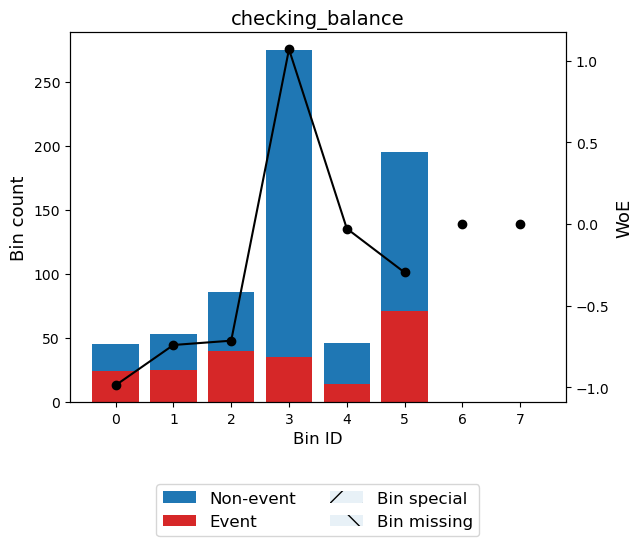

WoE for bin 0 = -0.9876412684542323
WoE for bin 1 = -0.7407811905227063
WoE for bin 2 = -0.7143479334545508
WoE for bin 3 = 1.071180986022868
WoE for bin 4 = -0.02743130264524174
WoE for bin 5 = -0.29650818726598804
OPTIMAL
[ 7.5 11.5 17.  26.5 33.  43.5]
months_loan_duration
          Variable Name             Bin  Count  Count (%)  Non-event  Event  \
0  months_loan_duration    (-inf, 7.50)     54   0.077143         48      6   
1  months_loan_duration   [7.50, 11.50)     62   0.088571         48     14   
2  months_loan_duration  [11.50, 17.00)    179   0.255714        134     45   
3  months_loan_duration  [17.00, 26.50)    239   0.341429        169     70   
4  months_loan_duration  [26.50, 33.00)     42   0.060000         29     13   
5  months_loan_duration  [33.00, 43.50)     73   0.104286         41     32   
6  months_loan_duration    [43.50, inf)     51   0.072857         22     29   

   Event rate       WoE        IV        JS  
0    0.111111  1.225332  0.084611  0.009961 

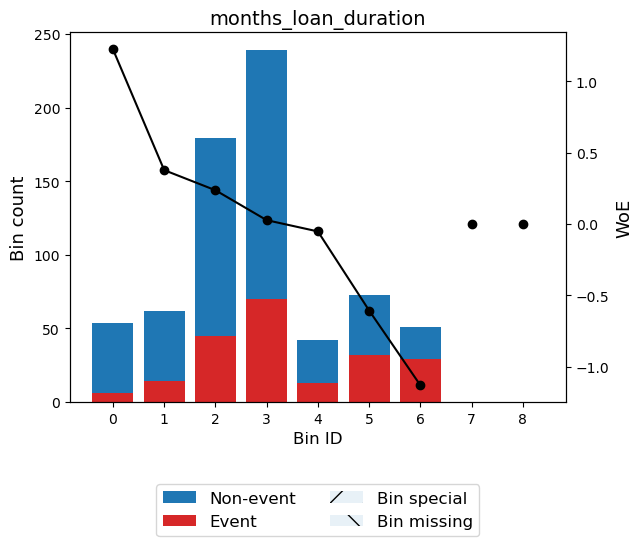

WoE for bin 0 = 1.2253316658501263
WoE for bin 1 = 0.37803380546292265
WoE for bin 2 = 0.23706743435088193
WoE for bin 3 = 0.02729359704400485
WoE for bin 4 = -0.051763403304772256
WoE for bin 5 = -0.6062737119251284
WoE for bin 6 = -1.130363252457868
OPTIMAL
[array(['critical'], dtype=object), array(['delayed'], dtype=object), array(['repaid'], dtype=object), array(['fully repaid this bank', 'fully repaid'], dtype=object)]
credit_history
    Variable Name                                        Bin  Count  \
0  credit_history                               ['critical']    211   
1  credit_history                                ['delayed']     65   
2  credit_history                                 ['repaid']    357   
3  credit_history  ['fully repaid this bank' 'fully repaid']     67   

   Count (%)  Non-event  Event  Event rate       WoE        IV        JS  
0   0.301429        179     32    0.151659   0.86754  0.183443  0.022237  
1   0.092857         47     18    0.276923  0.10566

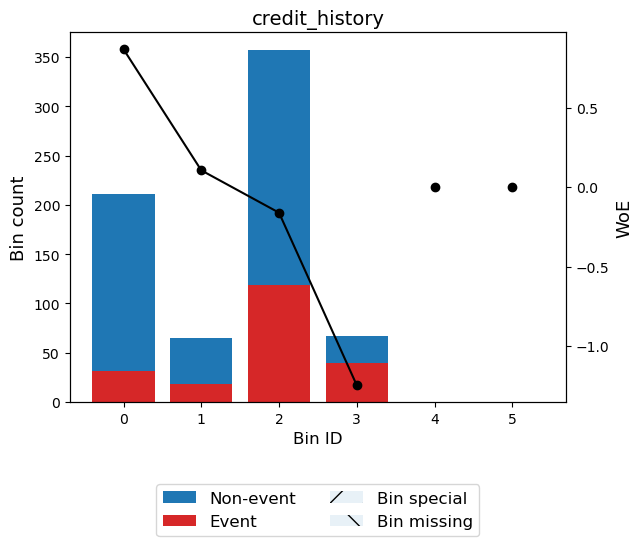

WoE for bin 0 = 0.867540027211319
WoE for bin 1 = 0.10566596798418429
WoE for bin 2 = -0.1609626952697643
WoE for bin 3 = -1.247152463939317
OPTIMAL
[array(['retraining', 'car (used)'], dtype=object), array(['radio/tv'], dtype=object), array(['furniture', 'repairs'], dtype=object), array(['business'], dtype=object), array(['car (new)', 'domestic appliances'], dtype=object), array(['education', 'others'], dtype=object)]
purpose
  Variable Name                                  Bin  Count  Count (%)  \
0       purpose          ['retraining' 'car (used)']     80   0.114286   
1       purpose                         ['radio/tv']    202   0.288571   
2       purpose              ['furniture' 'repairs']    134   0.191429   
3       purpose                         ['business']     65   0.092857   
4       purpose  ['car (new)' 'domestic appliances']    179   0.255714   
5       purpose               ['education' 'others']     40   0.057143   

   Non-event  Event  Event rate       WoE        I

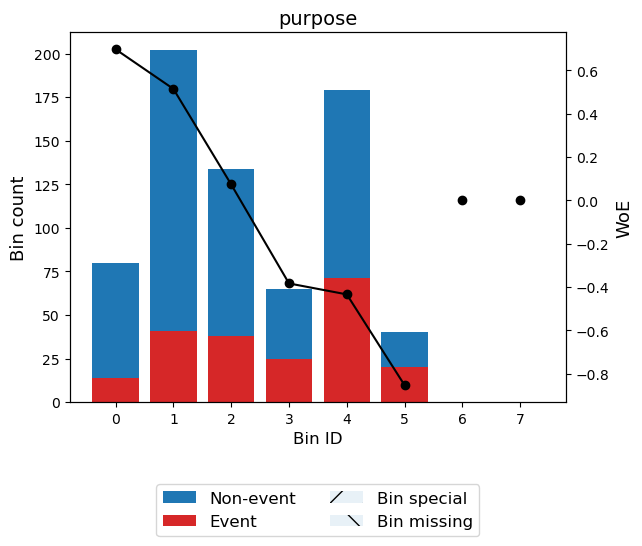

WoE for bin 0 = 0.6964875365814573
WoE for bin 1 = 0.5137224224504456
WoE for bin 2 = 0.07265215591174087
WoE for bin 3 = -0.38410624658397396
WoE for bin 4 = -0.43465852574680525
WoE for bin 5 = -0.8541098758297094
OPTIMAL
[1387.  3554.  3913.5 6322.5 7839.5]
amount
  Variable Name                 Bin  Count  Count (%)  Non-event  Event  \
0        amount     (-inf, 1387.00)    178   0.254286        120     58   
1        amount  [1387.00, 3554.00)    294   0.420000        227     67   
2        amount  [3554.00, 3913.50)     37   0.052857         34      3   
3        amount  [3913.50, 6322.50)     87   0.124286         56     31   
4        amount  [6322.50, 7839.50)     42   0.060000         27     15   
5        amount      [7839.50, inf)     62   0.088571         27     35   

   Event rate       WoE        IV        JS  
0    0.325843 -0.127061  0.004207  0.000526  
1    0.227891  0.366148  0.051901  0.006452  
2    0.081081  1.573638  0.086381  0.009805  
3    0.356322 -0.26274

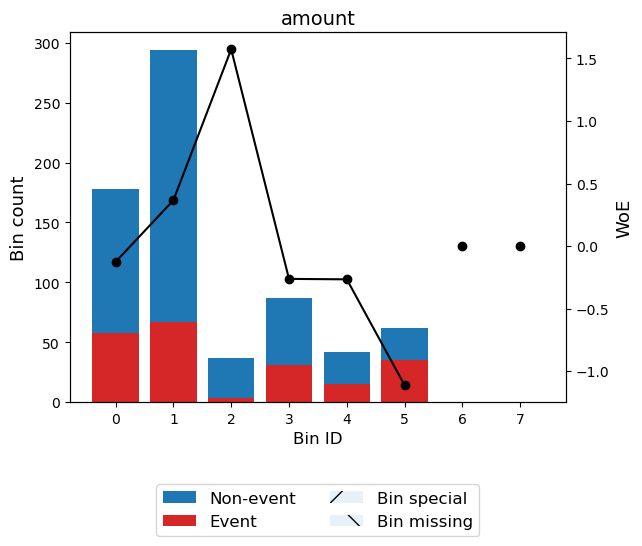

WoE for bin 0 = -0.12706114359408294
WoE for bin 1 = 0.3661475222607271
WoE for bin 2 = 1.5736383601183421
WoE for bin 3 = -0.26274538957970656
WoE for bin 4 = -0.26632321092759065
WoE for bin 5 = -1.1136210713147943
OPTIMAL
[5.000e-01 1.750e+01 4.450e+01 5.550e+01 9.050e+01 4.805e+02 9.945e+02]
savings_balance
     Variable Name               Bin  Count  Count (%)  Non-event  Event  \
0  savings_balance      (-inf, 0.50)    134   0.191429        104     30   
1  savings_balance     [0.50, 17.50)     75   0.107143         54     21   
2  savings_balance    [17.50, 44.50)    117   0.167143         70     47   
3  savings_balance    [44.50, 55.50)     37   0.052857         17     20   
4  savings_balance    [55.50, 90.50)    155   0.221429        104     51   
5  savings_balance   [90.50, 480.50)     99   0.141429         70     29   
6  savings_balance  [480.50, 994.50)     46   0.065714         39      7   
7  savings_balance     [994.50, inf)     37   0.052857         33      4   

  

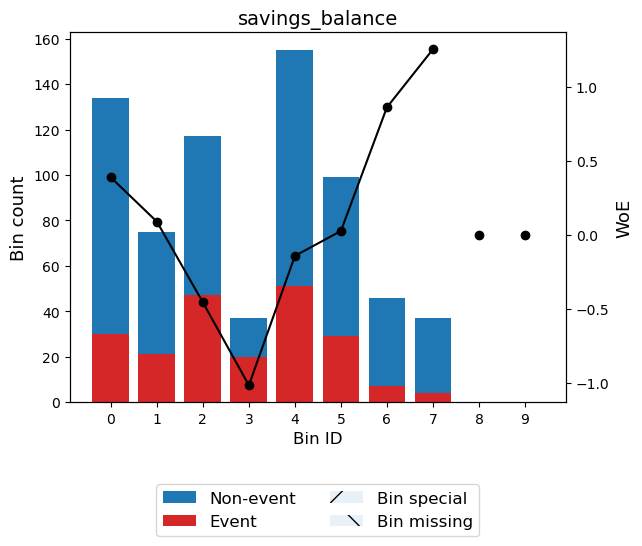

WoE for bin 0 = 0.38908364164950776
WoE for bin 1 = 0.09035173301114187
WoE for bin 2 = -0.45576223549040934
WoE for bin 3 = -1.0166288053274846
WoE for bin 4 = -0.14154460941266261
WoE for bin 5 = 0.02708953623317518
WoE for bin 6 = 0.8635416212446234
WoE for bin 7 = 1.25610332451688
OPTIMAL
[1.5 2.5 3.5]
installment_rate
      Variable Name           Bin  Count  Count (%)  Non-event  Event  \
0  installment_rate  (-inf, 1.50)     94   0.134286         69     25   
1  installment_rate  [1.50, 2.50)    162   0.231429        117     45   
2  installment_rate  [2.50, 3.50)    107   0.152857         76     31   
3  installment_rate   [3.50, inf)    337   0.481429        229    108   

   Event rate       WoE        IV        JS  
0    0.265957  0.161121  0.003369  0.000421  
1    0.277778  0.101402  0.002330  0.000291  
2    0.289720  0.042636  0.000275  0.000034  
3    0.320475 -0.102519  0.005162  0.000645  
IV for installment_rate = 0.01113686717172772
Since IV is less than 0.02, " ins

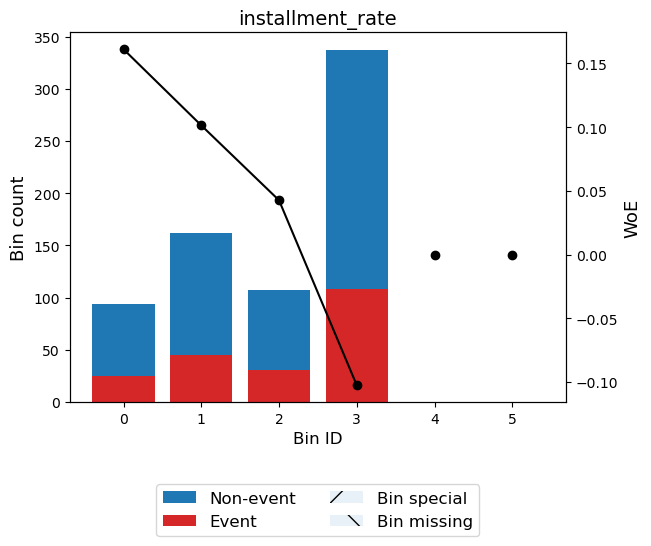

WoE for bin 0 = 0.1611208038993491
WoE for bin 1 = 0.10140156919772671
WoE for bin 2 = 0.0426362599714751
WoE for bin 3 = -0.10251909939968966
OPTIMAL
[array(['single'], dtype=object), array(['married'], dtype=object), array(['divorced', 'Unknown'], dtype=object)]
personal_status
     Variable Name                     Bin  Count  Count (%)  Non-event  \
0  personal_status              ['single']    385   0.550000        284   
1  personal_status             ['married']     64   0.091429         46   
2  personal_status  ['divorced' 'Unknown']    251   0.358571        161   

   Event  Event rate       WoE        IV        JS  
0    101    0.262338  0.179744  0.017104  0.002135  
1     18    0.281250   0.08416  0.000636  0.000080  
2     90    0.358566 -0.272515  0.027993  0.003488  
IV for personal_status = 0.04573314056741434
Since IV is between 0.02 and 0.5, " personal_status " should be used going forward.
The IV of " personal_status " is 0.04573314056741434 , which is weak predicti

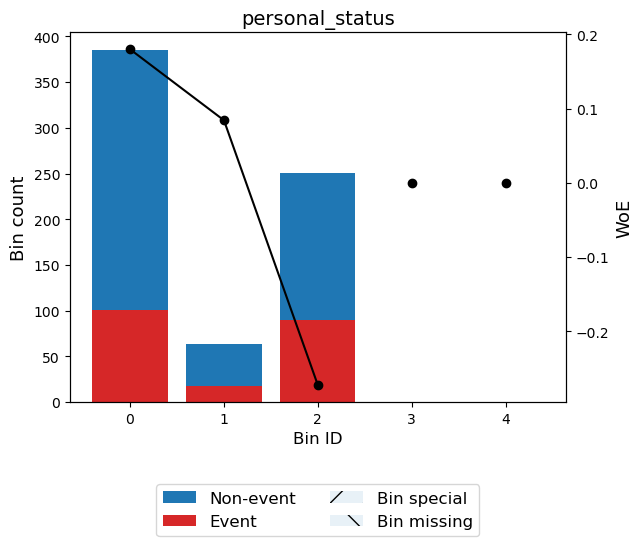

WoE for bin 0 = 0.17974384549023692
WoE for bin 1 = 0.0841597627632207
WoE for bin 2 = -0.27251518117551177
OPTIMAL
[array(['guarantor'], dtype=object), array(['none', 'co-applicant'], dtype=object)]
other_debtors
   Variable Name                      Bin  Count  Count (%)  Non-event  Event  \
0  other_debtors            ['guarantor']     40   0.057143         31      9   
1  other_debtors  ['none' 'co-applicant']    660   0.942857        460    200   

   Event rate       WoE        IV        JS  
0     0.22500  0.382653  0.007681  0.000954  
1     0.30303 -0.021201  0.000426  0.000053  
IV for other_debtors = 0.008107058329163948
Since IV is less than 0.02, " other_debtors " is not useful for prediction, thus should be NOT used going forward.


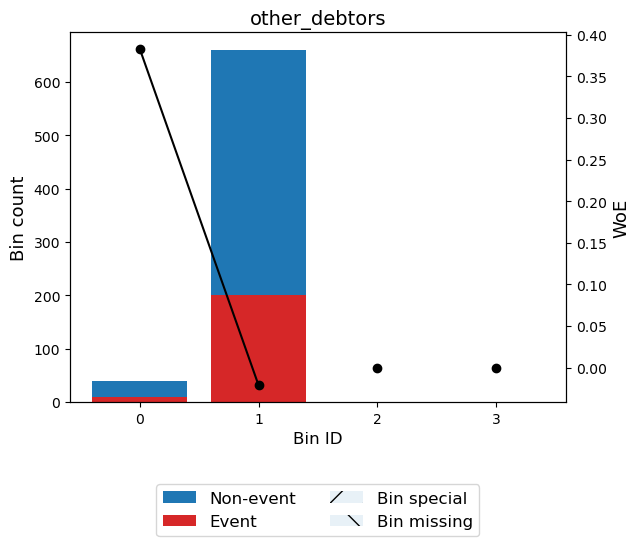

WoE for bin 0 = 0.3826527513192173
WoE for bin 1 = -0.021200752894605625
OPTIMAL
[array(['real estate'], dtype=object), array(['other'], dtype=object), array(['building society savings'], dtype=object), array(['unknown/none'], dtype=object)]
property
  Variable Name                           Bin  Count  Count (%)  Non-event  \
0      property               ['real estate']    197   0.281429        158   
1      property                     ['other']    234   0.334286        162   
2      property  ['building society savings']    162   0.231429        112   
3      property              ['unknown/none']    107   0.152857         59   

   Event  Event rate       WoE        IV        JS  
0     39    0.197970  0.544924  0.073668  0.009096  
1     72    0.307692  -0.04318  0.000629  0.000079  
2     50    0.308642 -0.047634  0.000530  0.000066  
3     48    0.448598 -0.647773  0.070933  0.008715  
IV for property = 0.1457591917382032
Since IV is between 0.02 and 0.5, " property " should be

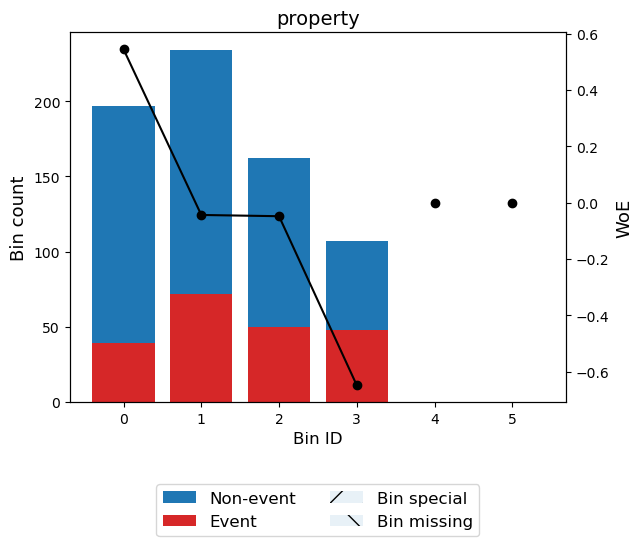

WoE for bin 0 = 0.5449235110676108
WoE for bin 1 = -0.04317965961338084
WoE for bin 2 = -0.047634009962761
WoE for bin 3 = -0.6477734428318811
OPTIMAL
[25.5 29.5 34.5 36.5]
age
  Variable Name             Bin  Count  Count (%)  Non-event  Event  \
0           age   (-inf, 25.50)    128   0.182857         71     57   
1           age  [25.50, 29.50)    136   0.194286         90     46   
2           age  [29.50, 34.50)    122   0.174286         86     36   
3           age  [34.50, 36.50)     50   0.071429         43      7   
4           age    [36.50, inf)    264   0.377143        201     63   

   Event rate       WoE        IV        JS  
0    0.445312 -0.634481  0.081293  0.009994  
1    0.338235 -0.182942  0.006732  0.000840  
2    0.295082  0.016718  0.000049  0.000006  
3    0.140000   0.96118  0.051984  0.006259  
4    0.238636   0.30606  0.033034  0.004113  
IV for age = 0.17309077989203564
Since IV is between 0.02 and 0.5, " age " should be used going forward.
The IV of " age

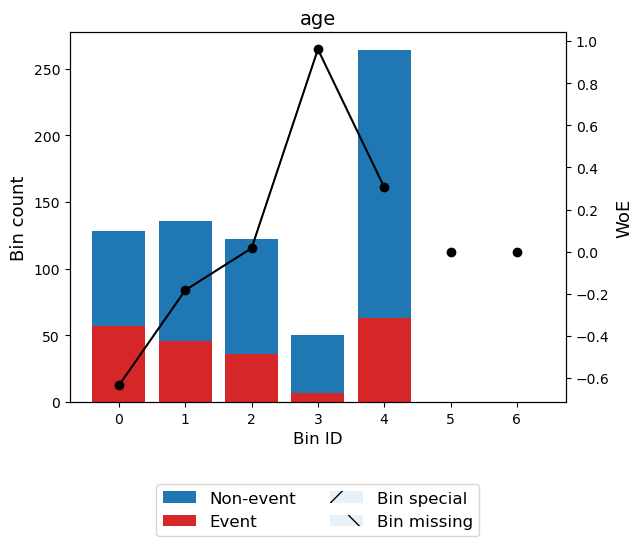

WoE for bin 0 = -0.6344812666229442
WoE for bin 1 = -0.1829416019885395
WoE for bin 2 = 0.01671848196768812
WoE for bin 3 = 0.9611800908085396
WoE for bin 4 = 0.3060603058378335
OPTIMAL
[array(['none'], dtype=object), array(['stores', 'bank'], dtype=object)]
installment_plan
      Variable Name                Bin  Count  Count (%)  Non-event  Event  \
0  installment_plan           ['none']    575   0.821429        414    161   
1  installment_plan  ['stores' 'bank']    125   0.178571         77     48   

   Event rate       WoE        IV        JS  
0       0.280  0.090352  0.006581  0.000822  
1       0.384 -0.381505  0.027790  0.003453  
IV for installment_plan = 0.034371145248594914
Since IV is between 0.02 and 0.5, " installment_plan " should be used going forward.
The IV of " installment_plan " is 0.034371145248594914 , which is weak predictive power.


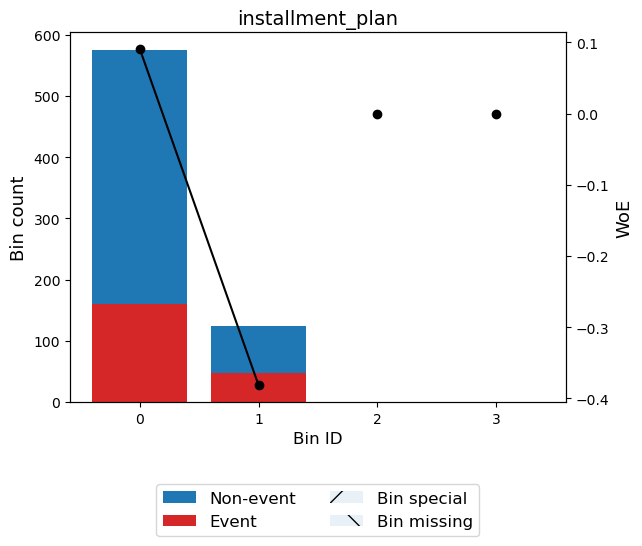

WoE for bin 0 = 0.09035173301114166
WoE for bin 1 = -0.3815054648839167
OPTIMAL
[array(['own'], dtype=object), array(['rent'], dtype=object), array(['for free'], dtype=object)]
housing
  Variable Name           Bin  Count  Count (%)  Non-event  Event  Event rate  \
0       housing       ['own']    502   0.717143        374    128    0.254980   
1       housing      ['rent']    122   0.174286         75     47    0.385246   
2       housing  ['for free']     76   0.108571         42     34    0.447368   

        WoE        IV        JS  
0  0.218116  0.032558  0.004062  
1 -0.386769  0.027898  0.003466  
2 -0.642801  0.049585  0.006094  
IV for housing = 0.11004174147153623
Since IV is between 0.02 and 0.5, " housing " should be used going forward.
The IV of " housing " is 0.11004174147153623 , which is medium predictive power.


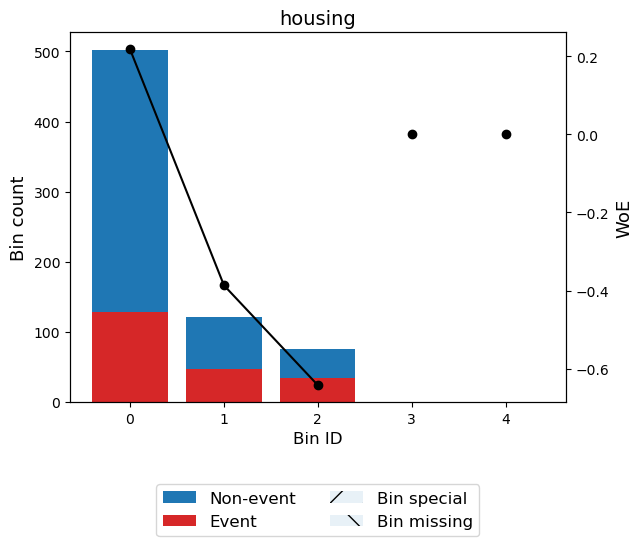

WoE for bin 0 = 0.21811565766520524
WoE for bin 1 = -0.3867693640034576
WoE for bin 2 = -0.6428007821625026
OPTIMAL
[1.5]
existing_credits
      Variable Name           Bin  Count  Count (%)  Non-event  Event  \
0  existing_credits  (-inf, 1.50)    435   0.621429        296    139   
1  existing_credits   [1.50, inf)    265   0.378571        195     70   

   Event rate       WoE        IV        JS  
0    0.319540 -0.098224  0.006112  0.000764  
1    0.264151  0.170394  0.010602  0.001324  
IV for existing_credits = 0.01671358138477968
Since IV is less than 0.02, " existing_credits " is not useful for prediction, thus should be NOT used going forward.


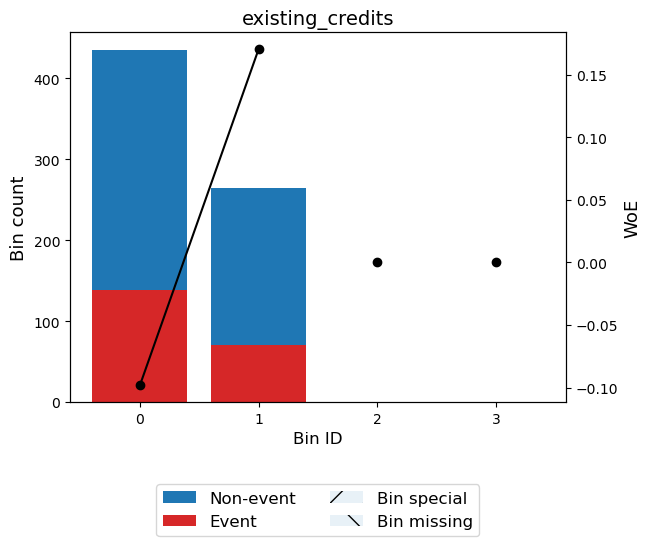

WoE for bin 0 = -0.098224354636341
WoE for bin 1 = 0.17039444068467816
OPTIMAL
[1.5]
dependents
  Variable Name           Bin  Count  Count (%)  Non-event  Event  Event rate  \
0    dependents  (-inf, 1.50)    604   0.862857        424    180    0.298013   
1    dependents   [1.50, inf)     96   0.137143         67     29    0.302083   

        WoE        IV            JS  
0  0.002667  0.000006  7.666072e-07  
1 -0.016713  0.000038  4.804474e-06  
IV for dependents = 4.456909856061991e-05
Since IV is less than 0.02, " dependents " is not useful for prediction, thus should be NOT used going forward.


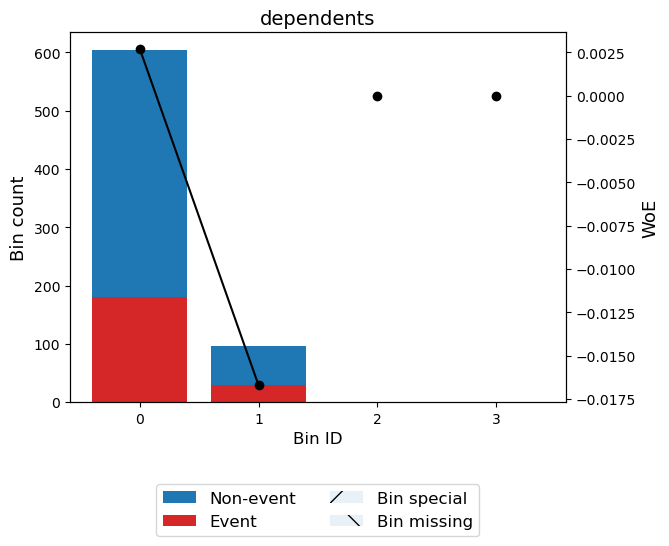

WoE for bin 0 = 0.0026667285120378663
WoE for bin 1 = -0.01671308642521754
OPTIMAL
[array(['no', 'yes'], dtype=object)]
foreign_worker
    Variable Name           Bin  Count  Count (%)  Non-event  Event  \
0  foreign_worker  ['no' 'yes']    700        1.0        491    209   

   Event rate  WoE   IV   JS  
0    0.298571 -0.0  0.0  0.0  
IV for foreign_worker = 0.0
Since IV is less than 0.02, " foreign_worker " is not useful for prediction, thus should be NOT used going forward.


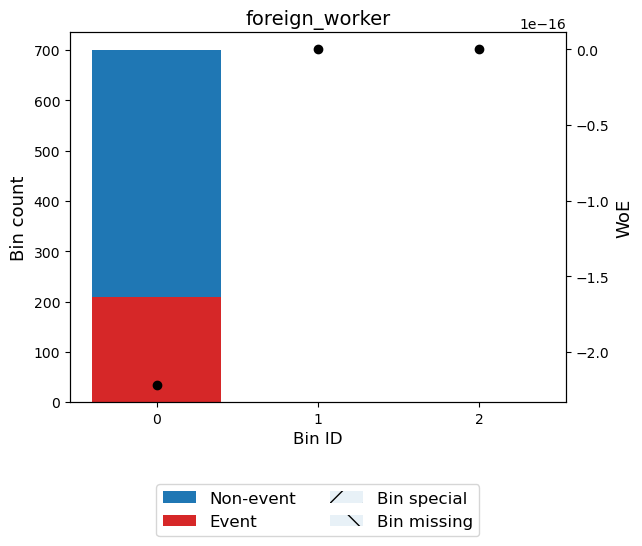

WoE for bin 0 = 0.0
OPTIMAL
[array(['unskilled resident'], dtype=object), array(['skilled employee'], dtype=object), array(['unemployed non-resident', 'mangement self-employed'], dtype=object)]
job
  Variable Name                                                Bin  Count  \
0           job                             ['unskilled resident']    129   
1           job                               ['skilled employee']    441   
2           job  ['unemployed non-resident' 'mangement self-emp...    130   

   Count (%)  Non-event  Event  Event rate       WoE        IV        JS  
0   0.184286         94     35    0.271318  0.133837  0.003210  0.000401  
1   0.630000        311    130    0.294785  0.018149  0.000207  0.000026  
2   0.185714         86     44    0.338462 -0.183952  0.006507  0.000812  
IV for job = 0.009923451868747844
Since IV is less than 0.02, " job " is not useful for prediction, thus should be NOT used going forward.


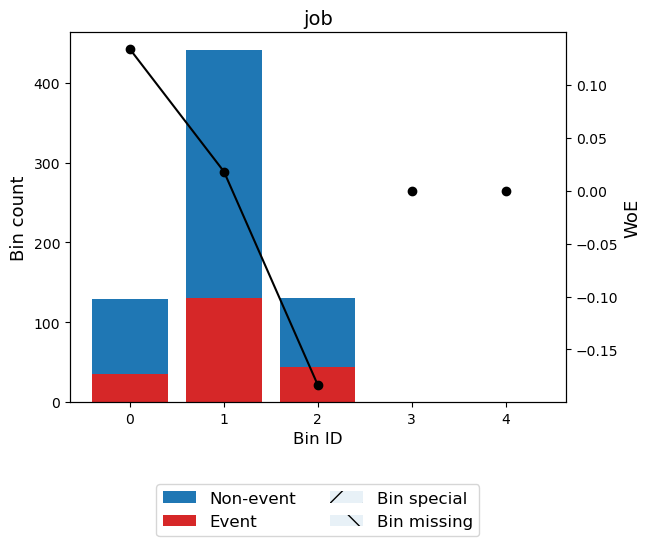

WoE for bin 0 = 0.13383684495088038
WoE for bin 1 = 0.018148585893942085
WoE for bin 2 = -0.18395221349446295
OPTIMAL
[array(['male'], dtype=object), array(['female'], dtype=object)]
gender
  Variable Name         Bin  Count  Count (%)  Non-event  Event  Event rate  \
0        gender    ['male']    478   0.682857        349    129    0.269874   
1        gender  ['female']    222   0.317143        142     80    0.360360   

        WoE        IV        JS  
0   0.14115  0.013207  0.001650  
1 -0.280309  0.026228  0.003268  
IV for gender = 0.039435681787566006
Since IV is between 0.02 and 0.5, " gender " should be used going forward.
The IV of " gender " is 0.039435681787566006 , which is weak predictive power.


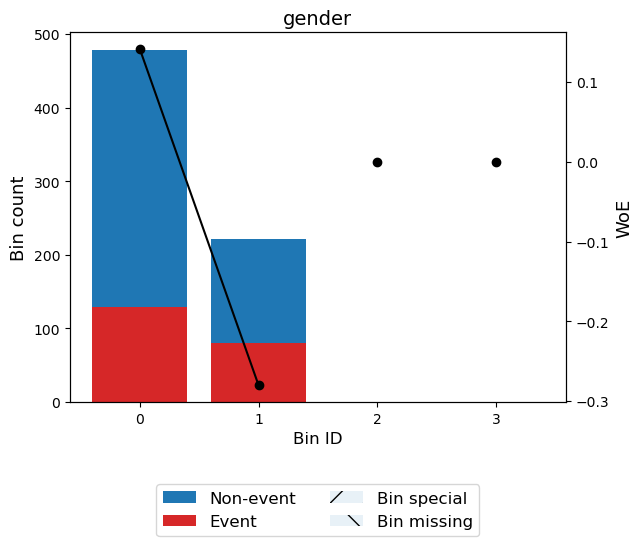

WoE for bin 0 = 0.14114964201104535
WoE for bin 1 = -0.28030945290233056
OPTIMAL
[ 0.29166667  3.5         5.5         7.5        10.5        15.5       ]
employment_length_years
             Variable Name             Bin  Count  Count (%)  Non-event  \
0  employment_length_years    (-inf, 0.29)     37   0.052857         20   
1  employment_length_years    [0.29, 3.50)    362   0.517143        245   
2  employment_length_years    [3.50, 5.50)     62   0.088571         44   
3  employment_length_years    [5.50, 7.50)     75   0.107143         56   
4  employment_length_years   [7.50, 10.50)     41   0.058571         32   
5  employment_length_years  [10.50, 15.50)     72   0.102857         59   
6  employment_length_years    [15.50, inf)     51   0.072857         35   

   Event  Event rate       WoE        IV        JS  
0     17    0.459459 -0.691591  0.028083  0.003442  
1    117    0.323204 -0.115026  0.006997  0.000874  
2     18    0.290323  0.039708  0.000139  0.000017  
3     19

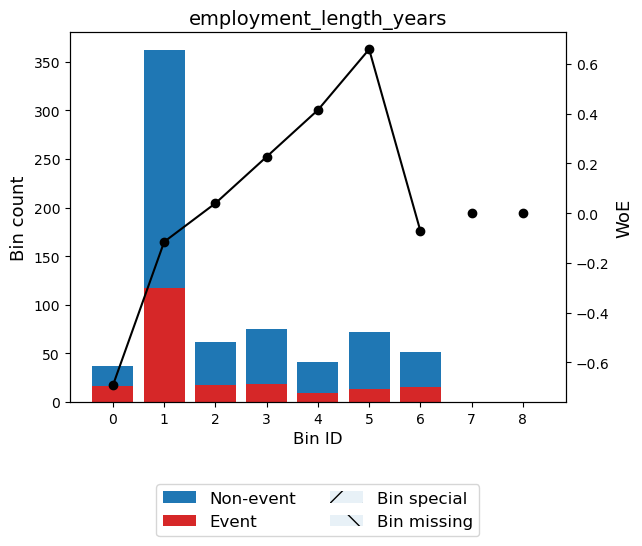

WoE for bin 0 = -0.6915909463319346
WoE for bin 1 = -0.11502560008273875
WoE for bin 2 = 0.039708000192386864
WoE for bin 3 = 0.22680283573899915
WoE for bin 4 = 0.41440144963379744
WoE for bin 5 = 0.6584782106144733
WoE for bin 6 = -0.07135053658007717
OPTIMAL
[ 0.29166667  0.54166666 13.5        18.5        21.5       ]
residence_history_years
             Variable Name             Bin  Count  Count (%)  Non-event  \
0  residence_history_years    (-inf, 0.29)     78   0.111429         47   
1  residence_history_years    [0.29, 0.54)     48   0.068571         33   
2  residence_history_years   [0.54, 13.50)    421   0.601429        299   
3  residence_history_years  [13.50, 18.50)     71   0.101429         57   
4  residence_history_years  [18.50, 21.50)     38   0.054286         27   
5  residence_history_years    [21.50, inf)     44   0.062857         28   

   Event  Event rate       WoE        IV        JS  
0     31    0.397436 -0.437949  0.023037  0.002857  
1     15    0.312500

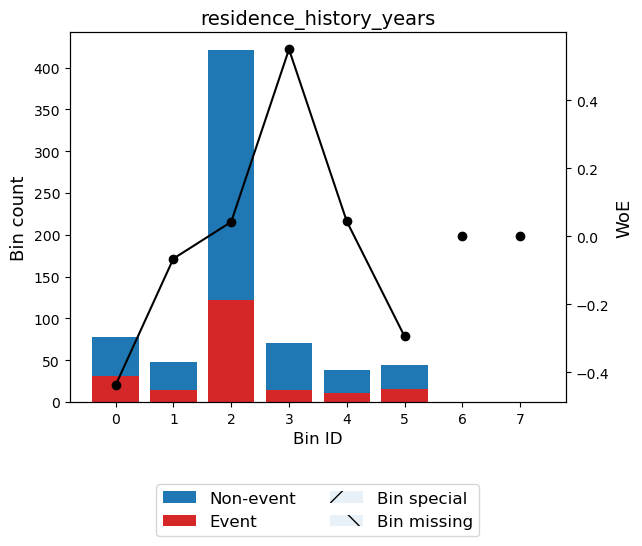

WoE for bin 0 = -0.4379494786047972
WoE for bin 1 = -0.06565251546543942
WoE for bin 2 = 0.04231265282772012
WoE for bin 3 = 0.5498840623895819
WoE for bin 4 = 0.043831717376248996
WoE for bin 5 = -0.29449408789428677
OPTIMAL
[ 5144.  5551.  6166.  8570.  9605. 16170. 23576.]
installment_rate_amount
             Variable Name                   Bin  Count  Count (%)  Non-event  \
0  installment_rate_amount       (-inf, 5144.00)    253   0.361429        185   
1  installment_rate_amount    [5144.00, 5551.00)     41   0.058571         31   
2  installment_rate_amount    [5551.00, 6166.00)     41   0.058571         38   
3  installment_rate_amount    [6166.00, 8570.00)    108   0.154286         82   
4  installment_rate_amount    [8570.00, 9605.00)     36   0.051429         23   
5  installment_rate_amount   [9605.00, 16170.00)    135   0.192857         86   
6  installment_rate_amount  [16170.00, 23576.00)     44   0.062857         28   
7  installment_rate_amount       [23576.00, inf)   

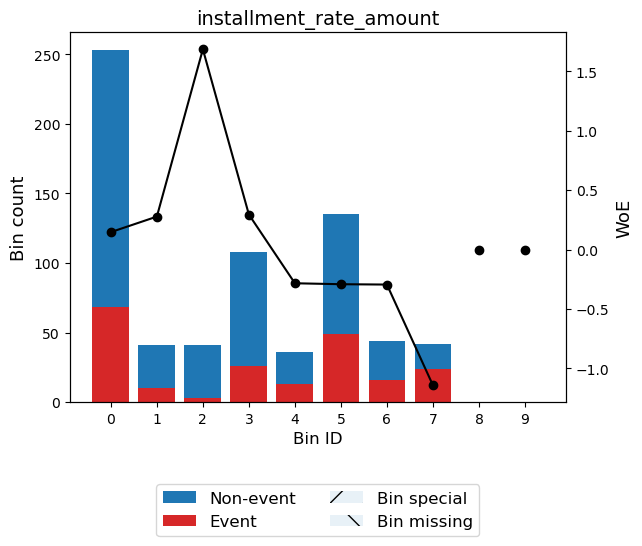

WoE for bin 0 = 0.14673824407250857
WoE for bin 1 = 0.2772922356613911
WoE for bin 2 = 1.6848639952285664
WoE for bin 3 = 0.29451283341306145
WoE for bin 4 = -0.2835650173620966
WoE for bin 5 = -0.2915828776868284
WoE for bin 6 = -0.29449408789428677
WoE for bin 7 = -1.1417919482814904
OPTIMAL
[4.32488523e-05 2.45577865e-03 1.06578027e-02 9.35816132e-02
 9.08968389e-01]
savings_to_amount_ratio
             Variable Name           Bin  Count  Count (%)  Non-event  Event  \
0  savings_to_amount_ratio  (-inf, 0.00)    134   0.191429        104     30   
1  savings_to_amount_ratio  [0.00, 0.00)     35   0.050000         16     19   
2  savings_to_amount_ratio  [0.00, 0.01)    108   0.154286         63     45   
3  savings_to_amount_ratio  [0.01, 0.09)    291   0.415714        199     92   
4  savings_to_amount_ratio  [0.09, 0.91)     94   0.134286         74     20   
5  savings_to_amount_ratio   [0.91, inf)     38   0.054286         35      3   

   Event rate       WoE        IV        J

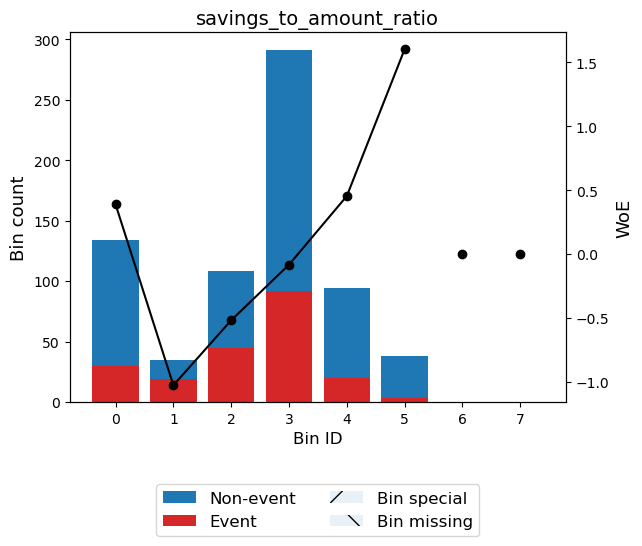

WoE for bin 0 = 0.38908364164950776
WoE for bin 1 = -1.0259601327563688
WoE for bin 2 = -0.5176376392084966
WoE for bin 3 = -0.0825936281542576
WoE for bin 4 = 0.45422294382046924
WoE for bin 5 = 1.6026258969915943
OPTIMAL
[ 1.27443606  2.4272728   3.40178573  4.34848499 12.2608695 ]
loan_duration_to_employment_length
                        Variable Name            Bin  Count  Count (%)  \
0  loan_duration_to_employment_length   (-inf, 1.27)     89   0.127143   
1  loan_duration_to_employment_length   [1.27, 2.43)    120   0.171429   
2  loan_duration_to_employment_length   [2.43, 3.40)     73   0.104286   
3  loan_duration_to_employment_length   [3.40, 4.35)     67   0.095714   
4  loan_duration_to_employment_length  [4.35, 12.26)    264   0.377143   
5  loan_duration_to_employment_length   [12.26, inf)     87   0.124286   

   Non-event  Event  Event rate       WoE        IV        JS  
0         74     15    0.168539  0.741905  0.058568  0.007158  
1         95     25    0.208333  

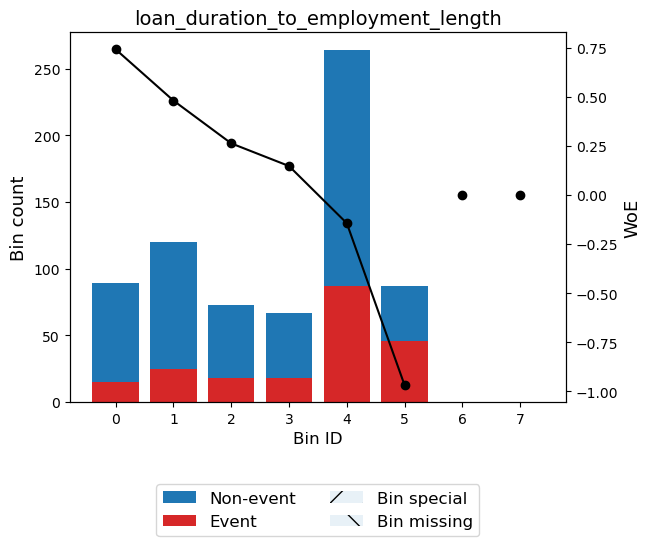

WoE for bin 0 = 0.7419050162722501
WoE for bin 1 = 0.48089119090263055
WoE for bin 2 = 0.2628515515065966
WoE for bin 3 = 0.14733866438475232
WoE for bin 4 = -0.14386826191046417
WoE for bin 5 = -0.9691792056144969
OPTIMAL
[0.01835017 0.0281746  0.0655914  0.07275132]
existing_credits_to_age
             Variable Name           Bin  Count  Count (%)  Non-event  Event  \
0  existing_credits_to_age  (-inf, 0.02)     36   0.051429         30      6   
1  existing_credits_to_age  [0.02, 0.03)    146   0.208571        106     40   
2  existing_credits_to_age  [0.03, 0.07)    427   0.610000        301    126   
3  existing_credits_to_age  [0.07, 0.07)     42   0.060000         28     14   
4  existing_credits_to_age   [0.07, inf)     49   0.070000         26     23   

   Event rate       WoE        IV        JS  
0    0.166667  0.755328  0.024466  0.002988  
1    0.273973   0.12045  0.002951  0.000369  
2    0.295082  0.016718  0.000170  0.000021  
3    0.333333 -0.160963  0.001603  0.00020

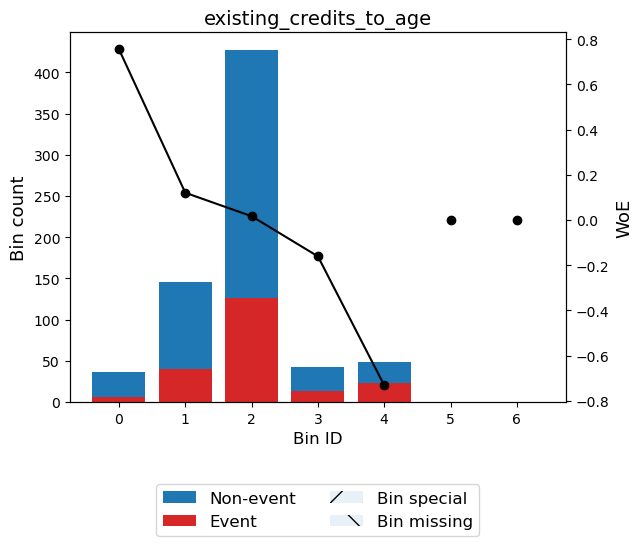

WoE for bin 0 = 0.7553280366043907
WoE for bin 1 = 0.12044976416842128
WoE for bin 2 = 0.01671848196768812
WoE for bin 3 = -0.1609626952697643
WoE for bin 4 = -0.7315075537373773
OPTIMAL
[  70.83970642  175.94537354 1135.09997559 2379.69238281 3732.84216309]
amount_to_years_at_residence
                  Variable Name                 Bin  Count  Count (%)  \
0  amount_to_years_at_residence       (-inf, 70.84)     43   0.061429   
1  amount_to_years_at_residence     [70.84, 175.95)    120   0.171429   
2  amount_to_years_at_residence   [175.95, 1135.10)    329   0.470000   
3  amount_to_years_at_residence  [1135.10, 2379.69)    114   0.162857   
4  amount_to_years_at_residence  [2379.69, 3732.84)     47   0.067143   
5  amount_to_years_at_residence      [3732.84, inf)     47   0.067143   

   Non-event  Event  Event rate       WoE        IV        JS  
0         36      7    0.162791  0.783499  0.031204  0.003804  
1         88     32    0.266667  0.157491  0.004113  0.000514  
2       

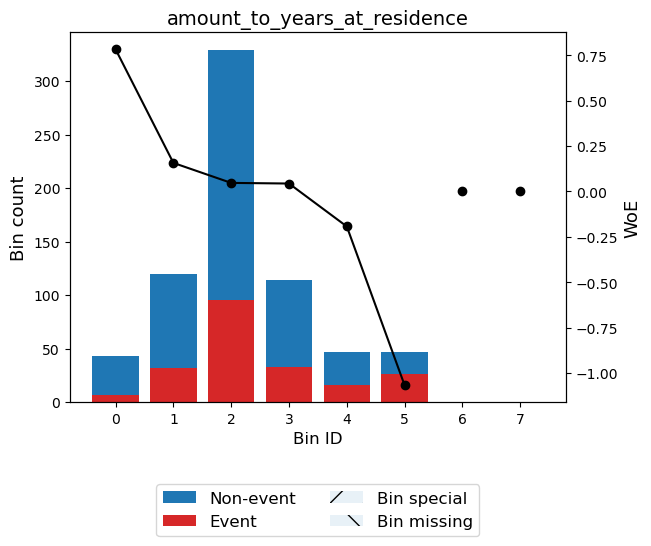

WoE for bin 0 = 0.7834989135710869
WoE for bin 1 = 0.1574910358487703
WoE for bin 2 = 0.04733434792745101
WoE for bin 3 = 0.043831717376248996
WoE for bin 4 = -0.19271139358434447
WoE for bin 5 = -1.0676839761277688
OPTIMAL
[ 0.65476191  0.9498747   1.43428576  2.0662055  19.08361149]
loan_duration_to_years_at_residence
                         Variable Name            Bin  Count  Count (%)  \
0  loan_duration_to_years_at_residence   (-inf, 0.65)     49   0.070000   
1  loan_duration_to_years_at_residence   [0.65, 0.95)     38   0.054286   
2  loan_duration_to_years_at_residence   [0.95, 1.43)     73   0.104286   
3  loan_duration_to_years_at_residence   [1.43, 2.07)     73   0.104286   
4  loan_duration_to_years_at_residence  [2.07, 19.08)    406   0.580000   
5  loan_duration_to_years_at_residence   [19.08, inf)     61   0.087143   

   Non-event  Event  Event rate       WoE        IV            JS  
0         43      6    0.122449  1.115331  0.065658  7.806616e-03  
1         29    

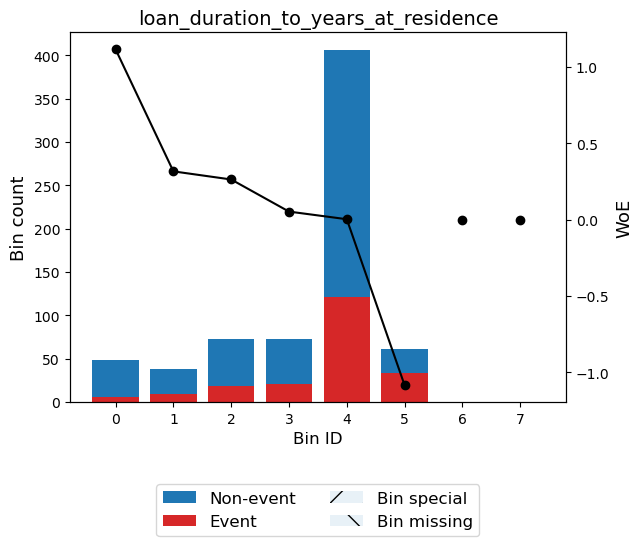

WoE for bin 0 = 1.1153307706357978
WoE for bin 1 = 0.31596137682054504
WoE for bin 2 = 0.2628515515065966
WoE for bin 3 = 0.05261140502829493
WoE for bin 4 = 0.002588758842199743
WoE for bin 5 = -1.0846335344415419
OPTIMAL
[0.05409357 0.13484849 7.05555558 9.28205109]
years_at_residence_per_month_of_loan_duration
                                   Variable Name           Bin  Count  \
0  years_at_residence_per_month_of_loan_duration  (-inf, 0.05)     48   
1  years_at_residence_per_month_of_loan_duration  [0.05, 0.13)     44   
2  years_at_residence_per_month_of_loan_duration  [0.13, 7.06)    521   
3  years_at_residence_per_month_of_loan_duration  [7.06, 9.28)     50   
4  years_at_residence_per_month_of_loan_duration   [9.28, inf)     37   

   Count (%)  Non-event  Event  Event rate       WoE        IV        JS  
0   0.068571         29     19    0.395833 -0.431253  0.013734  0.001704  
1   0.062857         21     23    0.522727 -0.945082  0.063583  0.007665  
2   0.744286        3

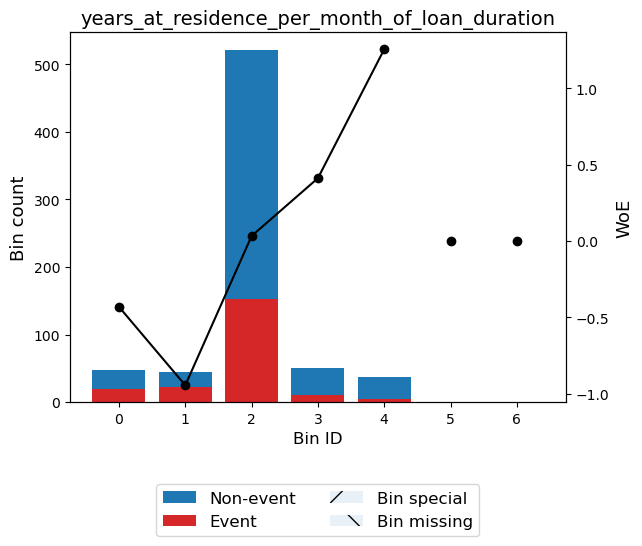

WoE for bin 0 = -0.43125302500967605
WoE for bin 1 = -0.9450816540354363
WoE for bin 2 = 0.03280624736454121
WoE for bin 3 = 0.41155649750156637
WoE for bin 4 = 1.25610332451688


In [2332]:
selected_variables = []

for variable in variable_names:
    x_in = X_train[variable].values
    y_in = y_train

    dtype = "numerical" if X_train[variable].dtype != 'object' else "categorical"
    optb = OptimalBinning(name=variable, dtype=dtype, solver="cp")
    optb.fit(x_in, y_in)
    
    print(optb.status)
    print(optb.splits)
    
    binning_table = optb.binning_table
    bt = binning_table.build() 

    # Ensure that `bt.Bin` is a string type, and replace any NaN values with an empty string to avoid errors
    bt['Bin'] = bt['Bin'].astype(str).fillna('')
    
    #create a "complete" list of binning tables that we will use for the final scorecard. 
    #drop the "Specials", "Missing", and "Totals" rows
    bt_to_add = bt[~bt.Bin.str.contains("Special")]
    bt_to_add = bt_to_add[~bt_to_add.Bin.str.contains("Missing")]  
    bt_to_add = bt_to_add.iloc[:-1 , :]

    #print variable
    print(color.DARKCYAN + variable + color.END)
    
    #prepare the data to be added to bt_complete
    bt_to_add.insert (0, "Variable Name", variable)
    bt_complete=bt_to_add #add these results to the complete results
    print(bt_complete)
           
    #check for IV
    x = sum(bt_complete['IV'])
    
    print('IV for', variable, '=', x)
    
    #analysis of IV value
    if x > 0.02 and x <0.5:
        selected_variables.append(variable)
        print('Since IV is between 0.02 and 0.5, "', variable, '" should be used going forward.')
        if x < 0.1:
            print('The IV of "', variable, '" is', x, ', which is weak predictive power.')
        elif x < 0.3:
            print('The IV of "', variable, '" is', x, ', which is medium predictive power.')
        else: 
            print('The IV of "', variable, '" is', x, ', which is strong predictive power.')
    elif x < 0.02:
        print('Since IV is less than 0.02, "', variable, '" is not useful for prediction, thus should be NOT used going forward.')
    else:
        print('Since IV is less than 0.02, ""', variable, '" has suspicious predictive power, thus should be NOT used going forward.')
    
    #check for monotonic value
    binning_table.plot(metric = 'woe')
    
    #check for WoE values
    for i in range(0, len(bt_complete)):
        gd = bt_complete.iloc[i]['Non-event'] / bt_complete['Non-event'].sum()
        bd = bt_complete.iloc[i]['Event'] / bt_complete['Event'].sum()
        WoE = np.log(gd / bd)
        print("WoE for bin", i, "=", WoE)

In [2333]:
bt_complete

,Variable Name,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,years_at_residence_per_month_of_loan_duration,"(-inf, 0.05)",48,0.068571,29,19,0.395833,-0.431253,0.013734,0.001704
1,years_at_residence_per_month_of_loan_duration,"[0.05, 0.13)",44,0.062857,21,23,0.522727,-0.945082,0.063583,0.007665
2,years_at_residence_per_month_of_loan_duration,"[0.13, 7.06)",521,0.744286,369,152,0.291747,0.032806,0.000796,0.000099
3,years_at_residence_per_month_of_loan_duration,"[7.06, 9.28)",50,0.071429,39,11,0.220000,0.411556,0.011029,0.001369
4,years_at_residence_per_month_of_loan_duration,"[9.28, inf)",37,0.052857,33,4,0.108108,1.256103,0.060382,0.007088


In [2334]:
list(selected_variables)

['months_loan_duration',
 'credit_history',
 'purpose',
 'amount',
 'savings_balance',
 'personal_status',
 'property',
 'age',
 'installment_plan',
 'housing',
 'gender',
 'employment_length_years',
 'residence_history_years',
 'installment_rate_amount',
 'savings_to_amount_ratio',
 'loan_duration_to_employment_length',
 'existing_credits_to_age',
 'amount_to_years_at_residence',
 'loan_duration_to_years_at_residence',
 'years_at_residence_per_month_of_loan_duration']

Section 3:
Generate a manual scorecard based on the Information Value (between 0.02 to 0.5) and perform the following.

Create a WOE transform matrix.
Compute the Logistic Regression and Regression Intercept.
Compute and print the scorecard manually.
Compare the WOE values generated in the manual scorecard to the WOE values generated in Q1.
Note: Refer to the appropriate formulas (factor, offset, score) in the credit scoring notes.

In [2335]:
import pandas as pd

def process_variable(variable, X_train, y_train, bt_complete, X_trans):
    """
    Process a variable to create a binning table and transform it using WoE.
    
    Parameters:
    - variable (str): The name of the variable to process.
    - X_train (DataFrame): The training features DataFrame.
    - y_train (Series): The target variable.
    - bt_complete (DataFrame): The complete binning table to which results will be appended.
    - X_trans (DataFrame): The DataFrame to which transformed variables will be added.

    Returns:
    - X_trans (DataFrame): Updated DataFrame containing all WoE transformed variables.
    - bt_complete (DataFrame): Updated complete binning table.
    """

    # Fit the Optimal Binning model
    x_in = X_train[variable].values
    dtype = "numerical" if X_train[variable].dtype != 'object' else "categorical"

    optb = OptimalBinning(name=variable, dtype=dtype, solver="cp")
    optb.fit(x_in, y_train)

    # Build the binning table
    binning_table = optb.binning_table
    bt_variable = binning_table.build() 

    # Prepare the binning table for appending
    bt_variable.insert(0, "Variable Name", variable)

    bt_variable['Bin'] = bt_variable['Bin'].astype(str).fillna('')

    # Drop the "Specials", "Missing", and "Totals" rows
    bt_to_add = bt_variable[~bt_variable.Bin.str.contains("Special")]
    bt_to_add = bt_to_add[~bt_to_add.Bin.str.contains("Missing")]  
    bt_to_add = bt_to_add.iloc[:-1, :]  # Remove "Totals"

    # Append to the complete result
    bt_complete = pd.concat([bt_complete, bt_to_add], ignore_index=True, axis=0)

    # Transform the variable and add WoE values to X_trans
    x_transform = optb.transform(X_train[variable], metric='woe')
    X_trans[f'{variable}_woe_trans'] = x_transform

    return X_trans, bt_complete

# Process each variable and accumulate results
X_trans = pd.DataFrame() 
for variable in selected_variables:
    X_trans, bt_complete = process_variable(variable, X_train, y_train, bt_complete, X_trans)

In [2336]:
bt_complete.head()

,Variable Name,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,years_at_residence_per_month_of_loan_duration,"(-inf, 0.05)",48,0.068571,29,19,0.395833,-0.431253,0.013734,0.001704
1,years_at_residence_per_month_of_loan_duration,"[0.05, 0.13)",44,0.062857,21,23,0.522727,-0.945082,0.063583,0.007665
2,years_at_residence_per_month_of_loan_duration,"[0.13, 7.06)",521,0.744286,369,152,0.291747,0.032806,0.000796,0.000099
3,years_at_residence_per_month_of_loan_duration,"[7.06, 9.28)",50,0.071429,39,11,0.220000,0.411556,0.011029,0.001369
4,years_at_residence_per_month_of_loan_duration,"[9.28, inf)",37,0.052857,33,4,0.108108,1.256103,0.060382,0.007088


Logistic Regression
We now have all of the variable we want included in the scorecard, and we have replaced the values of the original values with the corresponding WoE value for the bin the value falls in. We can now run the regression on X_trans, the WoE values, with the original good/bad (defaulted flag) values, y_train.

In [2337]:
X_trans.head()

,months_loan_duration_woe_trans,credit_history_woe_trans,purpose_woe_trans,amount_woe_trans,savings_balance_woe_trans,personal_status_woe_trans,property_woe_trans,age_woe_trans,installment_plan_woe_trans,housing_woe_trans,gender_woe_trans,employment_length_years_woe_trans,residence_history_years_woe_trans,installment_rate_amount_woe_trans,savings_to_amount_ratio_woe_trans,loan_duration_to_employment_length_woe_trans,existing_credits_to_age_woe_trans,amount_to_years_at_residence_woe_trans,loan_duration_to_years_at_residence_woe_trans,years_at_residence_per_month_of_loan_duration_woe_trans
0,0.027294,0.105666,-0.434659,0.366148,-0.141545,0.179744,-0.647773,0.30606,0.090352,-0.642801,0.141150,0.658478,0.042313,0.294513,-0.082594,0.480891,0.016718,0.047334,0.002589,0.032806
1,0.237067,-0.160963,-0.434659,0.366148,-0.141545,0.179744,-0.043180,0.30606,0.090352,0.218116,0.141150,0.414401,0.549884,0.294513,-0.082594,0.741905,0.120450,0.157491,1.115331,0.411556
2,-0.051763,-0.160963,0.072652,1.573638,1.256103,-0.272515,-0.047634,0.30606,0.090352,-0.386769,-0.280309,0.658478,0.042313,-0.291583,1.602626,0.480891,0.016718,0.047334,0.002589,0.032806
3,0.237067,0.867540,-0.434659,-0.127061,0.090352,0.179744,0.544924,0.30606,0.090352,0.218116,0.141150,0.226803,0.042313,0.146738,-0.517638,0.480891,0.016718,0.047334,0.002589,0.032806
4,-0.606274,0.867540,0.696488,-0.262745,1.256103,0.179744,-0.043180,0.30606,0.090352,0.218116,0.141150,0.414401,0.042313,-0.294494,1.602626,0.147339,0.016718,-0.192711,-1.084634,0.032806


In [2338]:
clf = LogisticRegression(solver="lbfgs").fit(X_trans, y_train)


In [2339]:
print("Regression Co-efficients:",np.round(clf.coef_[0],5))
print("Regression Intercept: ",np.round(clf.intercept_,5))
intr = np.round(clf.intercept_,5)

Regression Co-efficients: [-0.23565 -0.91009 -1.01405 -0.63039 -0.73752 -0.70296 -0.51468 -0.62035
 -0.34191 -0.5816  -0.1599  -0.72698 -0.8043  -0.59019 -0.37175  0.00208
 -0.7344   0.50247 -0.48942 -0.486  ]
Regression Intercept:  [-0.85386]


In [2340]:
clf.feature_names_in_


array(['months_loan_duration_woe_trans', 'credit_history_woe_trans',
       'purpose_woe_trans', 'amount_woe_trans',
       'savings_balance_woe_trans', 'personal_status_woe_trans',
       'property_woe_trans', 'age_woe_trans',
       'installment_plan_woe_trans', 'housing_woe_trans',
       'gender_woe_trans', 'employment_length_years_woe_trans',
       'residence_history_years_woe_trans',
       'installment_rate_amount_woe_trans',
       'savings_to_amount_ratio_woe_trans',
       'loan_duration_to_employment_length_woe_trans',
       'existing_credits_to_age_woe_trans',
       'amount_to_years_at_residence_woe_trans',
       'loan_duration_to_years_at_residence_woe_trans',
       'years_at_residence_per_month_of_loan_duration_woe_trans'],
      dtype=object)

In [2341]:
scorecard.table(style="detailed")


,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,months_loan_duration,0,"(-inf, 7.50)",54,0.077143,48,6,0.111111,1.225332,0.084611,0.009961,-0.474810,107.007467
1,months_loan_duration,1,"[7.50, 11.50)",62,0.088571,48,14,0.225806,0.378034,0.011634,0.001446,-0.474810,89.516887
2,months_loan_duration,2,"[11.50, 17.00)",179,0.255714,134,45,0.251397,0.237067,0.013655,0.001703,-0.474810,86.606949
3,months_loan_duration,3,"[17.00, 26.50)",239,0.341429,169,70,0.292887,0.027294,0.000253,0.000032,-0.474810,82.276635
4,months_loan_duration,4,"[26.50, 33.00)",42,0.060000,29,13,0.309524,-0.051763,0.000162,0.000020,-0.474810,80.644679
5,months_loan_duration,5,"[33.00, 43.50)",73,0.104286,41,32,0.438356,-0.606274,0.042201,0.005196,-0.474810,69.198047
6,months_loan_duration,6,"[43.50, inf)",51,0.072857,22,29,0.568627,-1.130363,0.106197,0.012610,-0.474810,58.379383
7,months_loan_duration,7,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,-0.474810,81.713219
8,months_loan_duration,8,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,-0.474810,81.713219
0,credit_history,0,[critical],211,0.301429,179,32,0.151659,0.867540,0.183443,0.022237,-0.934002,116.940993


In [2342]:
factor = 20/np.log(2)
offset = 600 - (factor * np.log(50))
n = clf.coef_.shape[1] #this is the number of independent variable we have
print("factor: ", factor,"\noffset: ",offset)

factor:  28.85390081777927 
offset:  487.1228762045055


In [2343]:
list(bt_complete['Variable Name'].unique()) 

['years_at_residence_per_month_of_loan_duration',
 'months_loan_duration',
 'credit_history',
 'purpose',
 'amount',
 'savings_balance',
 'personal_status',
 'property',
 'age',
 'installment_plan',
 'housing',
 'gender',
 'employment_length_years',
 'residence_history_years',
 'installment_rate_amount',
 'savings_to_amount_ratio',
 'loan_duration_to_employment_length',
 'existing_credits_to_age',
 'amount_to_years_at_residence',
 'loan_duration_to_years_at_residence']

In [2344]:
bt_complete['Variable Name'][3]

'years_at_residence_per_month_of_loan_duration'

In [2345]:
clf.feature_names_in_

array(['months_loan_duration_woe_trans', 'credit_history_woe_trans',
       'purpose_woe_trans', 'amount_woe_trans',
       'savings_balance_woe_trans', 'personal_status_woe_trans',
       'property_woe_trans', 'age_woe_trans',
       'installment_plan_woe_trans', 'housing_woe_trans',
       'gender_woe_trans', 'employment_length_years_woe_trans',
       'residence_history_years_woe_trans',
       'installment_rate_amount_woe_trans',
       'savings_to_amount_ratio_woe_trans',
       'loan_duration_to_employment_length_woe_trans',
       'existing_credits_to_age_woe_trans',
       'amount_to_years_at_residence_woe_trans',
       'loan_duration_to_years_at_residence_woe_trans',
       'years_at_residence_per_month_of_loan_duration_woe_trans'],
      dtype=object)

In [2346]:
# Step 1: Extract the "Variable" column from the scorecard
variable_names = scorecard.table(style="detailed")["Variable"].unique()

# Step 2: Create the coeff_dict dynamically
coeff_dict = {var_name: clf.coef_[0][i] for i, var_name in enumerate(variable_names)}

# Print the coefficients dictionary
print(coeff_dict)

{'months_loan_duration': -0.23564857915815568, 'credit_history': -0.9100853696098709, 'purpose': -1.014049951944517, 'amount': -0.6303941240390949, 'savings_balance': -0.7375229347347348, 'savings_to_amount_ratio': -0.7029642881415957, 'loan_duration_to_employment_length': -0.5146780727117686}


In [2347]:
# coeff_dict={bt_complete['Variable Name'][0]:clf.coef_[0][0],
#             bt_complete['Variable Name'][1]:clf.coef_[0][1],
#             bt_complete['Variable Name'][2]:clf.coef_[0][2],
#             bt_complete['Variable Name'][3]:clf.coef_[0][3],
#             bt_complete['Variable Name'][4]:clf.coef_[0][4],
#             bt_complete['Variable Name'][5]:clf.coef_[0][5],
#             bt_complete['Variable Name'][6]:clf.coef_[0][6],
#             bt_complete['Variable Name'][7]:clf.coef_[0][7],
#             bt_complete['Variable Name'][8]:clf.coef_[0][8],
#             bt_complete['Variable Name'][9]:clf.coef_[0][9],
#             bt_complete['Variable Name'][10]:clf.coef_[0][10],
#             bt_complete['Variable Name'][11]:clf.coef_[0][11],
#             bt_complete['Variable Name'][12]:clf.coef_[0][12]}

In [2348]:
# Assuming bt_complete has the column 'Variable Name' that corresponds to the keys in coeff_dict
# Ensure 'Variable Name' matches the keys in coeff_dict

# Modify the points calculation
bt_complete['points'] = bt_complete.apply(
    lambda row: -(
        pd.to_numeric(row.WoE, errors='coerce') *
        coeff_dict.get(row['Variable Name'], 0) +  # Use .get() to avoid KeyError
        intr/n
    ) * factor + offset/n,
    axis=1
)

# Display the result
bt_complete.head()

,Variable Name,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,points
0,years_at_residence_per_month_of_loan_duration,"(-inf, 0.05)",48,0.068571,29,19,0.395833,-0.431253,0.013734,0.001704,[25.588003397838722]
1,years_at_residence_per_month_of_loan_duration,"[0.05, 0.13)",44,0.062857,21,23,0.522727,-0.945082,0.063583,0.007665,[25.588003397838722]
2,years_at_residence_per_month_of_loan_duration,"[0.13, 7.06)",521,0.744286,369,152,0.291747,0.032806,0.000796,0.000099,[25.588003397838722]
3,years_at_residence_per_month_of_loan_duration,"[7.06, 9.28)",50,0.071429,39,11,0.220000,0.411556,0.011029,0.001369,[25.588003397838722]
4,years_at_residence_per_month_of_loan_duration,"[9.28, inf)",37,0.052857,33,4,0.108108,1.256103,0.060382,0.007088,[25.588003397838722]


In [2349]:
scorecard.table(style="detailed")


,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,months_loan_duration,0,"(-inf, 7.50)",54,0.077143,48,6,0.111111,1.225332,0.084611,0.009961,-0.474810,107.007467
1,months_loan_duration,1,"[7.50, 11.50)",62,0.088571,48,14,0.225806,0.378034,0.011634,0.001446,-0.474810,89.516887
2,months_loan_duration,2,"[11.50, 17.00)",179,0.255714,134,45,0.251397,0.237067,0.013655,0.001703,-0.474810,86.606949
3,months_loan_duration,3,"[17.00, 26.50)",239,0.341429,169,70,0.292887,0.027294,0.000253,0.000032,-0.474810,82.276635
4,months_loan_duration,4,"[26.50, 33.00)",42,0.060000,29,13,0.309524,-0.051763,0.000162,0.000020,-0.474810,80.644679
5,months_loan_duration,5,"[33.00, 43.50)",73,0.104286,41,32,0.438356,-0.606274,0.042201,0.005196,-0.474810,69.198047
6,months_loan_duration,6,"[43.50, inf)",51,0.072857,22,29,0.568627,-1.130363,0.106197,0.012610,-0.474810,58.379383
7,months_loan_duration,7,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,-0.474810,81.713219
8,months_loan_duration,8,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,-0.474810,81.713219
0,credit_history,0,[critical],211,0.301429,179,32,0.151659,0.867540,0.183443,0.022237,-0.934002,116.940993


In [2350]:
X_test.head(2)


,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,installment_rate,personal_status,other_debtors,property,...,gender,employment_length_years,residence_history_years,installment_rate_amount,savings_to_amount_ratio,loan_duration_to_employment_length,existing_credits_to_age,amount_to_years_at_residence,loan_duration_to_years_at_residence,years_at_residence_per_month_of_loan_duration
521,-39,18,repaid,radio/tv,3190,89,2,Unknown,none,real estate,...,female,2.0,0.0,6380,0.027891,6.0,0.040000,3190.000000,18.000000,0.0
737,-8,18,repaid,car (new),4380,157,3,single,none,other,...,male,2.0,18.0,13140,0.035837,6.0,0.027778,230.526316,0.947368,7.2


In [2351]:
X_test_score = scorecard.score(X_test)

In [2352]:
df = pd.DataFrame({"score":X_test_score, "good_bad":y_test})

In [2353]:
print("total number of records :",df.score.count())
print("total number of records where score >= 600 :",df.score[df.score >= 600].count())

total number of records : 300
total number of records where score >= 600 : 107


In [2354]:
max(X_test_score)


736.9088305063798

In [2355]:
min(X_test_score)

405.00130356698486

In [2356]:
print("total number of records :",df.score.count())
print("total number of records where score >= 460 :",df.score[df.score >= 950].count())

total number of records : 300
total number of records where score >= 460 : 0


In [2357]:
X_train.columns

Index(['checking_balance', 'months_loan_duration', 'credit_history', 'purpose',
       'amount', 'savings_balance', 'installment_rate', 'personal_status',
       'other_debtors', 'property', 'age', 'installment_plan', 'housing',
       'existing_credits', 'dependents', 'foreign_worker', 'job', 'gender',
       'employment_length_years', 'residence_history_years',
       'installment_rate_amount', 'savings_to_amount_ratio',
       'loan_duration_to_employment_length', 'existing_credits_to_age',
       'amount_to_years_at_residence', 'loan_duration_to_years_at_residence',
       'years_at_residence_per_month_of_loan_duration'],
      dtype='object')

2024-10-08 20:53:25,266 | INFO : Scorecard building process started.
2024-10-08 20:53:25,267 | INFO : Options: check parameters.
2024-10-08 20:53:25,267 | INFO : Dataset: binary target.
2024-10-08 20:53:25,268 | INFO : Binning process started.
2024-10-08 20:53:26,183 | INFO : Binning process terminated. Time: 0.9151s
2024-10-08 20:53:26,184 | INFO : Fitting estimator.
2024-10-08 20:53:26,186 | INFO : Fitting terminated. Time 0.0028s
2024-10-08 20:53:26,187 | INFO : Scorecard table building started.
2024-10-08 20:53:26,195 | INFO : Scorecard table terminated. Time: 0.0083s
2024-10-08 20:53:26,195 | INFO : Scorecard building process terminated. Time: 0.9289s


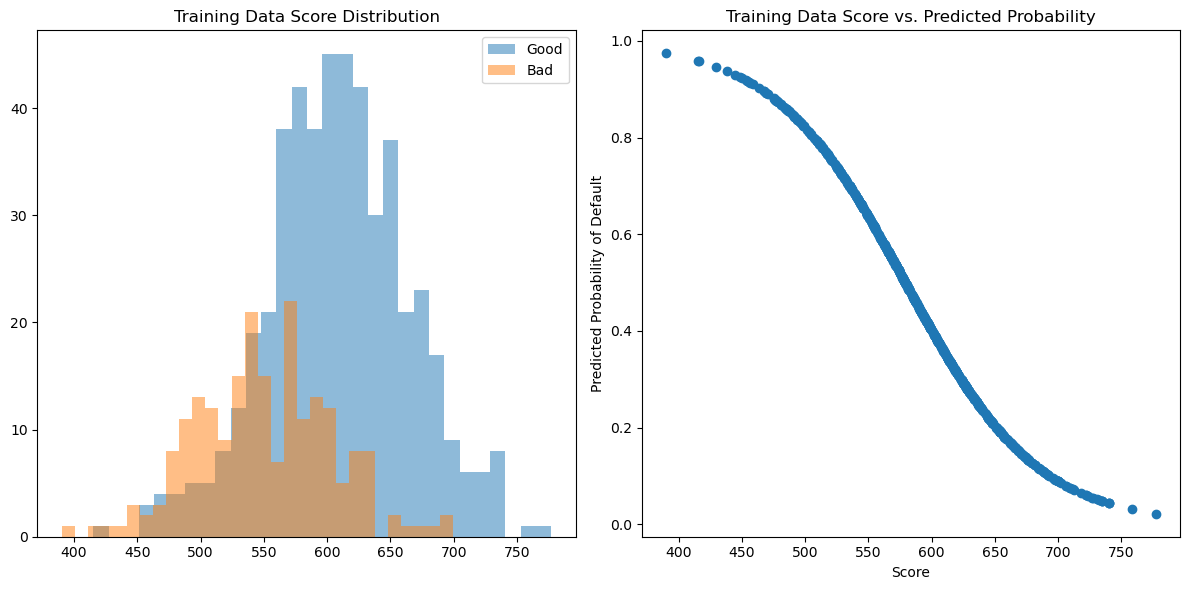

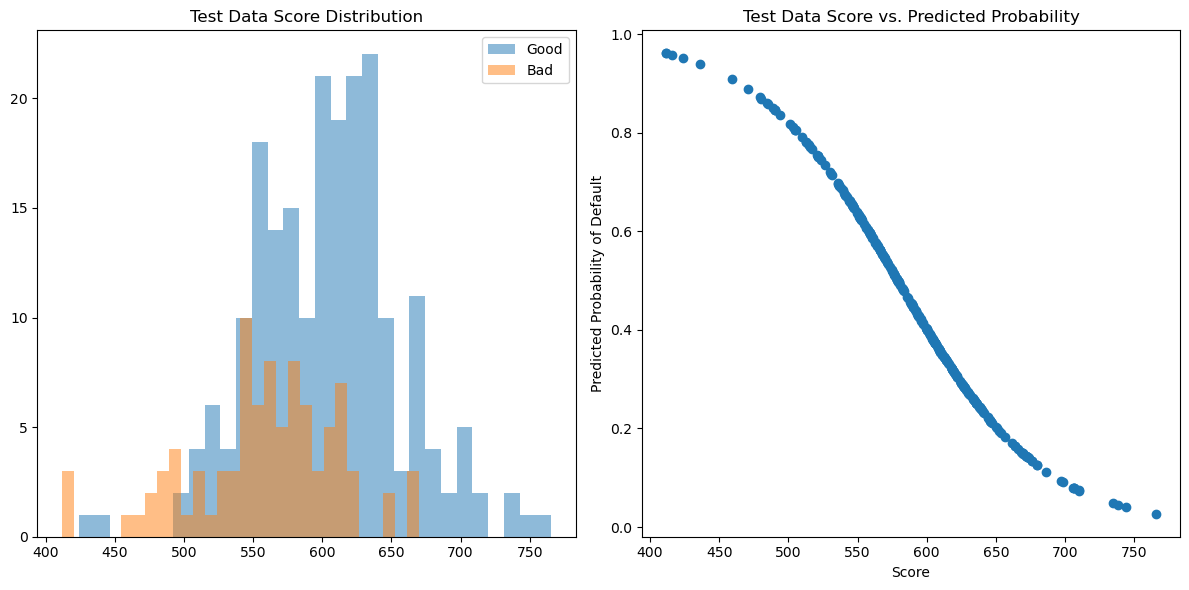

In [2358]:
# Fit the scorecard on the training dataset
scorecard.fit(X_train, y_train)

# Compute scores for both train and test datasets
train_score = scorecard.score(X_train)
test_score = scorecard.score(X_test)

# Compute predicted probabilities for both train and test datasets
train_pred_proba = scorecard.predict_proba(X_train)
test_pred_proba = scorecard.predict_proba(X_test)

# Visualizations for training data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(train_score[y_train == 0], alpha=0.5, label="Good", bins=30)
plt.hist(train_score[y_train == 1], alpha=0.5, label="Bad", bins=30)
plt.title("Training Data Score Distribution")
plt.legend()

# Scatter plot for training data
plt.subplot(1, 2, 2)
plt.scatter(train_score, train_pred_proba[:, 1])
plt.title("Training Data Score vs. Predicted Probability")
plt.xlabel("Score")
plt.ylabel("Predicted Probability of Default")
plt.tight_layout()
plt.show()

# Visualizations for test data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(test_score[y_test == 0], alpha=0.5, label="Good", bins=30)
plt.hist(test_score[y_test == 1], alpha=0.5, label="Bad", bins=30)
plt.title("Test Data Score Distribution")
plt.legend()

# Scatter plot for test data
plt.subplot(1, 2, 2)
plt.scatter(test_score, test_pred_proba[:, 1])
plt.title("Test Data Score vs. Predicted Probability")
plt.xlabel("Score")
plt.ylabel("Predicted Probability of Default")
plt.tight_layout()
plt.show()

In [2359]:
from sklearn.metrics import roc_auc_score

test_pred = scorecard.predict_proba(X_test)[:, 1]
train_pred = scorecard.predict_proba(X_train)[:, 1]


# Assuming y_test is the actual target labels for the test set
# y_pred is the predicted probabilities from scorecard (probability of positive class)
auc_test = roc_auc_score(y_test, test_pred)
auc_train = roc_auc_score(y_train, train_pred)
# Calculate Gini coefficient
gini_test = 2 * auc_test - 1
gini_train = 2 * auc_train - 1

print(f"Gini Coefficient for Training Data: {gini_train:.4f} and Gini coefficient - Test: {gini_test:.4f}")


Gini Coefficient for Training Data: 0.5620 and Gini coefficient - Test: 0.4502


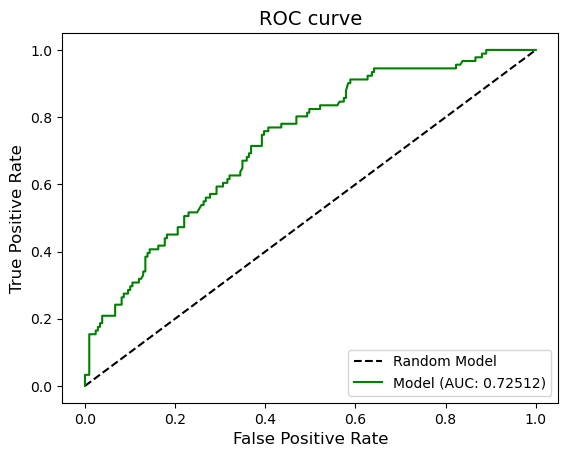

In [2360]:
plot_auc_roc(y_test, test_pred)


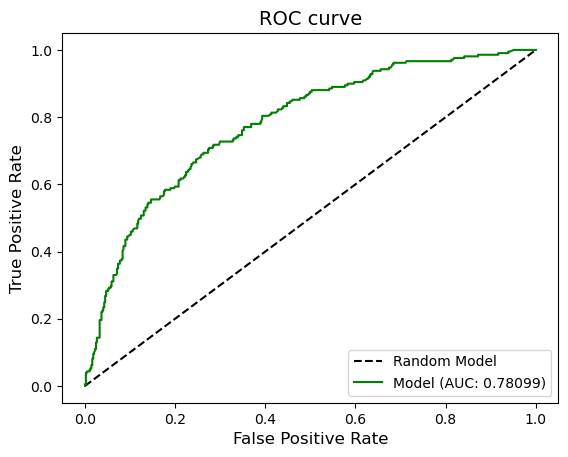

In [2361]:
plot_auc_roc(y_train,train_pred)


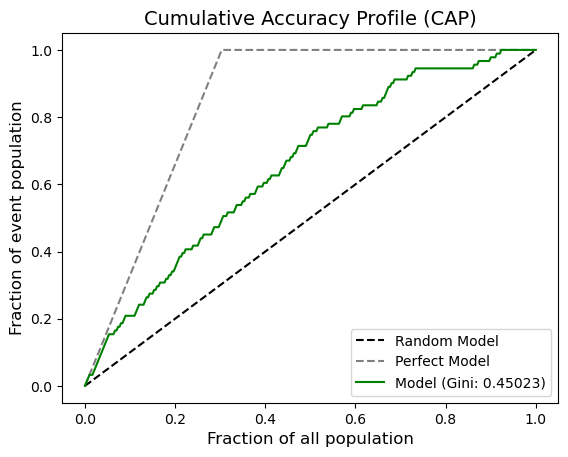

In [2362]:
plot_cap(y_test, test_pred)


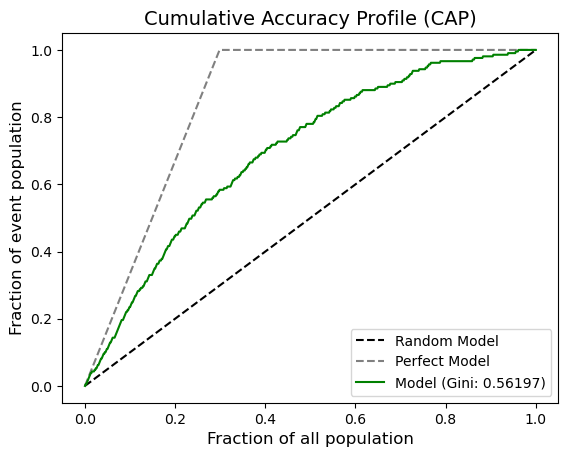

In [2363]:
plot_cap(y_train,train_pred)

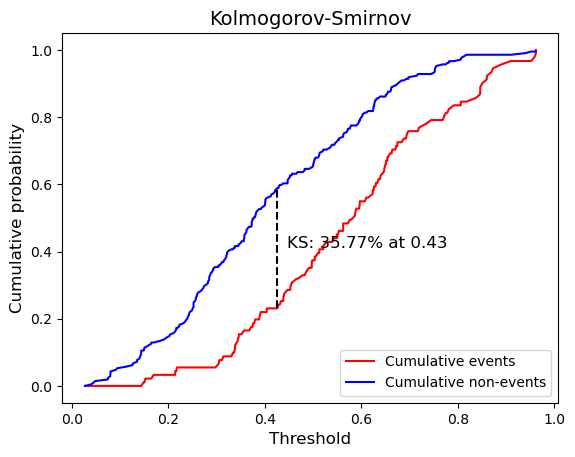

In [2364]:
plot_ks(y_test, test_pred)


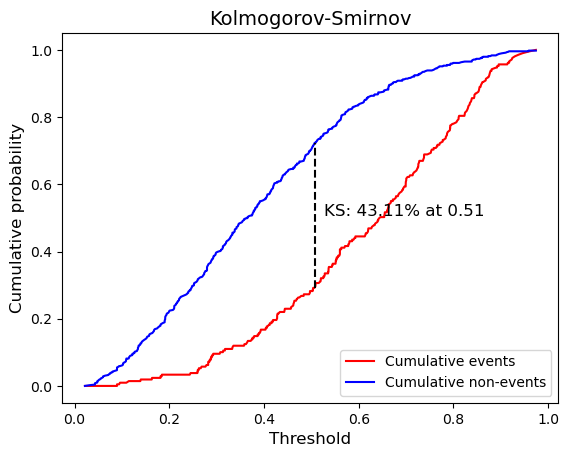

In [2365]:
plot_ks(y_train,train_pred)


In [2366]:
scorecard_monitoring = ScorecardMonitoring(scorecard=scorecard,
                    psi_method='cart',
                    psi_n_bins=5,
                    verbose=True)

In [2367]:
# Convert predicted probabilities into binary outcomes (0 or 1)
y_pred_binary = (test_pred >= 0.5).astype(int)

# Now fit the scorecard monitoring
scorecard_monitoring.fit(X_test, y_test, X_test, y_pred_binary)


2024-10-08 20:53:27,203 | INFO : Monitoring started.
2024-10-08 20:53:27,204 | INFO : Options: check parameters.
2024-10-08 20:53:27,206 | INFO : System stability analysis started.
2024-10-08 20:53:27,226 | INFO : System stability analysis terminated. Time: 0.0197s
2024-10-08 20:53:27,226 | INFO : Variable analysis started.
2024-10-08 20:53:27,232 | INFO : Variable analysis terminated. Time: 0.0050s
2024-10-08 20:53:27,232 | INFO : Monitoring terminated. Time: 0.0286s


/Users/macbookpro/anaconda3/envs/renmoney_m1/lib/python3.10/site-packages/optbinning/metrics/classification.py:104: RuntimeWarning: divide by zero encountered in double_scalars
  dp = np.sqrt(3) / np.pi * (np.log(tpr / (1-tnr)) + np.log(tnr / (1-tpr)))


ScorecardMonitoring(psi_n_bins=5,
                    scorecard=Scorecard(binning_process=BinningProcess(categorical_variables=['credit_history',
                                                                                              'purpose',
                                                                                              'personal_status',
                                                                                              'other_debtors',
                                                                                              'property',
                                                                                              'installment_plan',
                                                                                              'housing',
                                                                                              'foreign_worker',
                                                                                              'job',
                                                                                              'gender'],
                                                                       max_n_bins=8,
                                                                       min_n_bins=2,
                                                                       selection_criteria={'gini': {'min': 0.02},
                                                                                           'iv': {'max': 0.5,
                                                                                                  'min': 0.02,
                                                                                                  'strategy': 'high...
                                                                                       'savings_to_amount_ratio',
                                                                                       'loan_duration_to_employment_length',
                                                                                       'existing_credits_to_age',
                                                                                       'amount_to_years_at_residence',
                                                                                       'loan_duration_to_years_at_residence',
                                                                                       'years_at_residence_per_month_of_loan_duration']),
                                        estimator=LogisticRegression(class_weight='balanced'),
                                        scaling_method='min_max',
                                        scaling_method_params={'max': 800,
                                                               'min': 350},
                                        verbose=True),
                    verbose=True)

In [2368]:
scorecard_monitoring.psi_variable_table()

,Variable,PSI
0,credit_history,0.0
1,loan_duration_to_employment_length,0.0
2,months_loan_duration,0.0
3,purpose,0.0
4,savings_balance,0.0
5,savings_to_amount_ratio,0.0


In [2369]:
scorecard_monitoring.system_stability_report()

-----------------------------------
Monitoring: System Stability Report
-----------------------------------

  Population Stability Index (PSI)


    PSI total:      0.0000 (No significant change)

         PSI bin  Count  Count (%)
    [0.00, 0.10)      2        1.0
    [0.10, 0.25)      0        0.0
    [0.25, Inf+)      0        0.0

  Significance tests (H0: actual == expected)

     p-value bin  Count  Count (%)
    [0.00, 0.05)      2        1.0
    [0.05, 0.10)      0        0.0
    [0.10, 0.50)      0        0.0
    [0.50, 1.00)      0        0.0

  Target analysis

               Metric  Actual Actual (%)  Expected Expected (%)
    Number of records     300          -       300            -
        Event records      91   0.303333       129         0.43
    Non-event records     209   0.696667       171         0.57

  Performance metrics

                 Metric   Actual  Expected  Diff A - E
     True positive rate 0.626374       1.0   -0.373626
     True negative rate 0.655

In [2370]:
scorecard_monitoring.information()

optbinning (Version 0.19.0)
Copyright (c) 2019-2024 Guillermo Navas-Palencia, Apache License 2.0

  Statistics
    Number of records Actual             300
    Number of records Expected           300
    Number of scorecard variables          6
    Target type                       binary

  Timing
    Total time                          0.03 sec
    System stability                    0.02 sec   ( 68.97%)
    Variables stability                 0.01 sec   ( 17.56%)



In [2371]:
import mlflow
import mlflow.sklearn
import pickle
from sklearn.metrics import roc_auc_score
from datetime import datetime
import os
from sklearn.model_selection import train_test_split, KFold
from optbinning import BinningProcess, Scorecard  # Ensure you import the necessary classes
from sklearn.linear_model import LogisticRegression  # Ensure this is imported

# Set experiment name (optional)
mlflow.set_experiment("Credit_Scoring_Model_Optimization")

# Updated selection criteria params
selection_criteria = {
    "iv": {"min": 0.02, "max": 0.5, 'strategy': "highest", 'top': 10},
    "quality_score": {"min": 0.01},
    "gini": {"min": 0.02}
}

train_test_ratio = 0.7  # Adjusted to 0.7 for training (30% test)

# Gini calculation (function, assuming it's based on AUC)
def calculate_gini(y_true, y_pred_proba):
    auc = roc_auc_score(y_true, y_pred_proba)
    gini = 2 * auc - 1
    return gini

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store metrics
gini_scores = []

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1 - train_test_ratio), random_state=42)

# Extract categorical and numerical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

max_n_bins = 8
min_n_bins = 2

# Initialize the Binning Process
binning_process = BinningProcess(
    variable_names=numerical_features + categorical_features,  # Ensure to include all features
    categorical_variables=categorical_features,
    special_codes=[],
    selection_criteria=selection_criteria,
    min_n_bins=min_n_bins,
    max_n_bins=max_n_bins
)

# Initialize the Logistic Regression estimator
estimator = LogisticRegression(solver="lbfgs", class_weight='balanced')

# Initialize the Scorecard
scorecard = Scorecard(
    binning_process=binning_process,
    estimator=estimator,
    scaling_method="min_max",  # You can adjust the scaling method here
    scaling_method_params={"min": 350, "max": 800},
    intercept_based=False,
    reverse_scorecard=False,
    verbose=True
)

# Start an MLflow run
with mlflow.start_run():
    
    # Log selection criteria parameters
    for criterion, params in selection_criteria.items():
        for key, value in params.items():
            mlflow.log_param(f"{criterion}_{key}", value)
    
    mlflow.log_param("train_test_ratio", train_test_ratio)
    mlflow.log_param("max_n_bins", max_n_bins)
    mlflow.log_param("min_n_bins", min_n_bins)

    

    # K-Fold Cross-Validation
    for train_index, test_index in kf.split(X):
        X_fold_train, X_fold_test = X.iloc[train_index], X.iloc[test_index]
        y_fold_train, y_fold_test = y.iloc[train_index], y.iloc[test_index]

        # Fit the Scorecard
        scorecard.fit(X_fold_train, y_fold_train)

        # Calculate and log Gini for this fold
        fold_pred_proba = scorecard.predict_proba(X_fold_test)[:, 1]
        gini_fold = calculate_gini(y_fold_test, fold_pred_proba)
        gini_scores.append(gini_fold)
        mlflow.log_metric("gini_fold", gini_fold)

    # Log average Gini score across folds
    avg_gini = np.mean(gini_scores)
    mlflow.log_metric("avg_gini_cv", avg_gini)

    # Fit the final model on the entire training data
    scorecard.fit(X_train, y_train)

    # Count unique variables from the scorecard
    unique_variables_count = scorecard.table(style="detailed")["Variable"].unique().size
    
    # Log the count of unique variables
    mlflow.log_param("unique_variables_count", unique_variables_count)

    # Log the fitted model using MLflow
    mlflow.sklearn.log_model(scorecard, "credit_scoring_model")

    # Calculate and log Gini for train
    train_pred_proba = scorecard.predict_proba(X_train)[:, 1]
    gini_train = calculate_gini(y_train, train_pred_proba)
    mlflow.log_metric("gini_train", gini_train)
    
    # Calculate and log Gini for test
    test_pred_proba = scorecard.predict_proba(X_test)[:, 1]
    gini_test = calculate_gini(y_test, test_pred_proba)
    mlflow.log_metric("gini_test", gini_test)

    # Generate today's date
    today_date = datetime.today().strftime('%Y-%m-%d')

    # Directory path to save the model
    directory = "Credit Scoring Model/models"
    os.makedirs(directory, exist_ok=True)  # Create directory if it doesn't exist

    # File path with Gini and date
    file_name = f"{directory}/logit_model_{gini_test:.2f}_Gini_{today_date}.pkl"

    # Save the model as a .pkl file
    with open(file_name, 'wb') as file:
        pickle.dump(scorecard, file)  # Ensure you're saving the fitted scorecard

    # Log the .pkl model file as artifact
    mlflow.log_artifact(file_name)

print("Model and metrics logged successfully!")

2024-10-08 20:53:27,346 | INFO : Scorecard building process started.
2024-10-08 20:53:27,346 | INFO : Options: check parameters.
2024-10-08 20:53:27,347 | INFO : Dataset: binary target.
2024-10-08 20:53:27,347 | INFO : Binning process started.
2024-10-08 20:53:28,237 | INFO : Binning process terminated. Time: 0.8892s
2024-10-08 20:53:28,237 | INFO : Fitting estimator.
2024-10-08 20:53:28,240 | INFO : Fitting terminated. Time 0.0030s
2024-10-08 20:53:28,241 | INFO : Scorecard table building started.
2024-10-08 20:53:28,252 | INFO : Scorecard table terminated. Time: 0.0117s
2024-10-08 20:53:28,253 | INFO : Scorecard building process terminated. Time: 0.9063s
2024-10-08 20:53:28,259 | INFO : Scorecard building process started.
2024-10-08 20:53:28,259 | INFO : Options: check parameters.
2024-10-08 20:53:28,260 | INFO : Dataset: binary target.
2024-10-08 20:53:28,260 | INFO : Binning process started.
2024-10-08 20:53:29,201 | INFO : Binning process terminated. Time: 0.9412s
2024-10-08 20:53

In [2372]:
get_ipython().system_raw("mlflow ui --port 5003 &")


[2024-10-08 20:53:36 +0500] [61075] [INFO] Starting gunicorn 20.1.0
[2024-10-08 20:53:36 +0500] [61075] [ERROR] Connection in use: ('127.0.0.1', 5003)
[2024-10-08 20:53:36 +0500] [61075] [ERROR] Retrying in 1 second.
[2024-10-08 20:53:37 +0500] [61075] [ERROR] Connection in use: ('127.0.0.1', 5003)
[2024-10-08 20:53:37 +0500] [61075] [ERROR] Retrying in 1 second.
[2024-10-08 20:53:38 +0500] [61075] [ERROR] Connection in use: ('127.0.0.1', 5003)
[2024-10-08 20:53:38 +0500] [61075] [ERROR] Retrying in 1 second.
[2024-10-08 20:53:39 +0500] [61075] [ERROR] Connection in use: ('127.0.0.1', 5003)
[2024-10-08 20:53:39 +0500] [61075] [ERROR] Retrying in 1 second.
[2024-10-08 20:53:40 +0500] [61075] [ERROR] Connection in use: ('127.0.0.1', 5003)
[2024-10-08 20:53:40 +0500] [61075] [ERROR] Retrying in 1 second.
[2024-10-08 20:53:41 +0500] [61075] [ERROR] Can't connect to ('127.0.0.1', 5003)
Running the mlflow server failed. Please see the logs above for details.


In [2375]:
import os
import pickle
from datetime import datetime

# Generate today's date
today_date = datetime.today().strftime('%Y-%m-%d')

# Directory path to save the model
directory = "Credit Scoring Model/models"
os.makedirs(directory, exist_ok=True)  # Create directory if it doesn't exist

# Verify if the directory was created
if os.path.exists(directory):
    print("Directory created successfully!")
else:
    print("Failed to create directory.")

# File path with Gini and date
file_name = f"{directory}/logit_model_{gini_test:.2f}_Gini_{today_date}.pkl"
print("File path for saving model:", file_name)

# Save the model as a .pkl file
try:
    with open(file_name, 'wb') as file:
        pickle.dump(scorecard, file)  # Ensure you're saving the fitted scorecard
    print(f"Model saved successfully at {file_name}")
except Exception as e:
    print(f"Error saving model: {e}")

Directory created successfully!
File path for saving model: Credit Scoring Model/models/logit_model_0.45_Gini_2024-10-08.pkl
Model saved successfully at Credit Scoring Model/models/logit_model_0.45_Gini_2024-10-08.pkl


[2024-10-08 21:30:47 +0500] [60326] [CRITICAL] WORKER TIMEOUT (pid:60462)
[2024-10-08 21:30:47 +0500] [60326] [CRITICAL] WORKER TIMEOUT (pid:60471)
[2024-10-08 21:30:47 +0500] [60326] [CRITICAL] WORKER TIMEOUT (pid:60474)
[2024-10-08 21:30:47 +0500] [60326] [CRITICAL] WORKER TIMEOUT (pid:60478)
[2024-10-08 21:30:47 +0500] [60478] [INFO] Worker exiting (pid: 60478)
[2024-10-08 21:30:47 +0500] [60462] [INFO] Worker exiting (pid: 60462)
[2024-10-08 21:30:47 +0500] [60471] [INFO] Worker exiting (pid: 60471)
[2024-10-08 21:30:47 +0500] [60474] [INFO] Worker exiting (pid: 60474)
[2024-10-08 21:30:48 +0500] [60326] [WARNING] Worker with pid 60471 was terminated due to signal 9
[2024-10-08 21:30:48 +0500] [60326] [WARNING] Worker with pid 60474 was terminated due to signal 9
[2024-10-08 21:30:48 +0500] [60326] [WARNING] Worker with pid 60462 was terminated due to signal 9
[2024-10-08 21:30:48 +0500] [61333] [INFO] Booting worker with pid: 61333
[2024-10-08 21:30:48 +0500] [61336] [INFO] Bootin